## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.glacioclim_preprocess import *
from scripts.plots import *
from scripts.config_FR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.FranceConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/GLACIOCLIM/')

In [2]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [4]:
data_glacioclim = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm_with_blanc.csv')

print('Number of glaciers:', len(data_glacioclim['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_glacioclim[data_glacioclim.PERIOD == 'annual']) + len(data_glacioclim[data_glacioclim.PERIOD == 'winter']) + len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_glacioclim[data_glacioclim.PERIOD == 'winter']))
#print('Number of summer samples:',
      #len(data_glacioclim[data_glacioclim.PERIOD == 'summer']))

data_glacioclim = data_glacioclim[data_glacioclim['PERIOD'] != 'summer']

data_glacioclim.columns


Number of glaciers: 9
Number of winter, summer and annual samples: 10762
Number of annual samples: 4785
Number of winter samples: 3281


Index(['POINT_ID', 'POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE',
       'TO_DATE', 'POINT_BALANCE', 'GLACIER', 'PERIOD', 'GLACIER_ZONE', 'YEAR',
       'DATA_MODIFICATION', 'RGIId', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

## Input data:
### Input dataset:

In [5]:
data_glacioclim_test = data_glacioclim.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_glacioclim_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'FR_wgms_dataset_monthly_full_no_summer_with_blanc.csv')
data_monthly = dataloader_gl.data

2025-09-06 17:41:10,064 - INFO - Loaded preprocessed data.
2025-09-06 17:41:10,065 - INFO - Number of monthly rows: 81534
2025-09-06 17:41:10,077 - INFO - Number of annual samples: 57592
2025-09-06 17:41:10,084 - INFO - Number of winter samples: 23942


In [6]:
unique_glaciers = data_glacioclim_test['GLACIER'].value_counts()
print(unique_glaciers)

GLACIER
FR4N01235A08 dArgentiere               2513
FR4N01162B09+154D03 de Saint Sorlin    2163
FR4N01146D09+E06 Gebroulaz             1285
FR4N01236A01 Mer de Glace/Geant        1185
FR4N01236A01 Leschaux                   302
FR4N01236A07 de Talefre                 272
FR4N01083B21 Blanc                      267
FR4N01163A02 de Sarennes 1               68
FR4N01236A02 des Grands Montets          11
Name: count, dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import ks_2samp
import random

# CONFIG: features to match distributions on and desired test fraction
features = ['ELEVATION_DIFFERENCE', 't2m', 'ssrd', 'POINT_LAT', 'POINT_LON']   # extend if needed
test_frac = 0.25
K = 2   # number of strata/clusters
seed = cfg.seed

# 1) glacier-level summaries
df = dataloader_gl.data.copy()
gl_stats = df.groupby('GLACIER')[features].agg(['mean','std','count'])
# flatten columns
gl_stats.columns = ['_'.join(col).strip() for col in gl_stats.columns.values]
gl_stats = gl_stats.reset_index()

# use means (and optionally std) to form clustering features
cluster_cols = [c for c in gl_stats.columns if c.endswith('_mean')]
X = gl_stats[cluster_cols].fillna(0).values
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# 2) KMeans strata
kmeans = KMeans(n_clusters=K, random_state=seed, n_init=10)
gl_stats['stratum'] = kmeans.fit_predict(Xs)

# 3) stratified sampling of glaciers to get approx test_frac rows
test_glaciers = []
random.seed(seed)
for s, gdf in gl_stats.groupby('stratum'):
    glaciers_in_stratum = list(gdf['GLACIER'].values)
    # choose by groups (glaciers) but try to maintain approximate row fraction:
    # compute number of rows available per glacier then pick until reaching fraction
    rows = df[df.GLACIER.isin(glaciers_in_stratum)].groupby('GLACIER').size().to_dict()
    total_rows = sum(rows.values())
    target_rows = int(total_rows * test_frac)
    # greedy random pick until reach target_rows
    gls = glaciers_in_stratum.copy()
    random.shuffle(gls)
    picked = []
    acc = 0
    for g in gls:
        if acc >= target_rows:
            break
        picked.append(g)
        acc += rows[g]
    test_glaciers.extend(picked)

# Ensure uniqueness and no overlap
test_glaciers = list(dict.fromkeys(test_glaciers))
existing_glaciers = set(df.GLACIER.unique())
test_glaciers = [g for g in test_glaciers if g in existing_glaciers]

train_glaciers = [g for g in existing_glaciers if g not in test_glaciers]

data_test = df[df.GLACIER.isin(test_glaciers)].copy()
data_train = df[df.GLACIER.isin(train_glaciers)].copy()

print("Train rows:", len(data_train), "Test rows:", len(data_test),
      "Ratio train/test rows ≈", round(len(data_train)/max(1,len(data_test)),2))
print("Train glaciers:", len(train_glaciers), "Test glaciers:", len(test_glaciers))

# 4) Diagnostics: KS test for each feature
print("\nKS p-values (train vs test) for key features:")
for f in features:
    p = ks_2samp(data_train[f].dropna(), data_test[f].dropna()).pvalue
    print(f, "KS p:", p, "train mean/std:", data_train[f].mean(), data_train[f].std(),
          "test mean/std:", data_test[f].mean(), data_test[f].std())

display('test :', test_glaciers)
display('train :', train_glaciers)

Train rows: 40507 Test rows: 41027 Ratio train/test rows ≈ 0.99
Train glaciers: 6 Test glaciers: 3

KS p-values (train vs test) for key features:
ELEVATION_DIFFERENCE KS p: 0.0 train mean/std: 515.0683470517885 498.3817395051633 test mean/std: 416.9529415060713 286.4030322849428
t2m KS p: 6.020120840765869e-146 train mean/std: -0.8541356327651027 6.8814871188487485 test mean/std: -2.058881240953699 6.957321174948232
ssrd KS p: 2.0371506155941818e-11 train mean/std: 13655970.408670107 6271018.91416236 test mean/std: 13699356.0951081 6145709.405960624
POINT_LAT KS p: 0.0 train mean/std: 45.40384270496309 0.37000583042533575 test mean/std: 45.74702095658487 0.2987340097522095
POINT_LON KS p: 0.0 train mean/std: 6.4583410136609105 0.3636152449790964 test mean/std: 6.885964779522233 0.1706434487347836


'test :'

['FR4N01236A07 de Talefre',
 'FR4N01235A08 dArgentiere',
 'FR4N01146D09+E06 Gebroulaz']

'train :'

['FR4N01163A02 de Sarennes 1',
 'FR4N01236A02 des Grands Montets',
 'FR4N01236A01 Mer de Glace/Geant',
 'FR4N01162B09+154D03 de Saint Sorlin',
 'FR4N01083B21 Blanc',
 'FR4N01236A01 Leschaux']

## Blocking on glaciers:

In [7]:
#test_glaciers = ['FR4N01146D09+E06 Gebroulaz']

# Regional 50%
test_glaciers = ['FR4N01236A07 de Talefre','FR4N01235A08 dArgentiere', 'FR4N01146D09+E06 Gebroulaz']

# 3rd try 5-10% or 653 IDs
#test_glaciers = ['FR4N01235A08 dArgentiere' ,'FR4N01146D09+E06 Gebroulaz' ,'FR4N01236A01 Mer de Glace/Geant','FR4N01162B09+154D03 de Saint Sorlin', 'FR4N01083B21 Blanc']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 41027
Size of train data: 40507
Percentage of test size: 101.28%
Train glaciers: (6) ['FR4N01083B21 Blanc' 'FR4N01236A01 Mer de Glace/Geant'
 'FR4N01236A01 Leschaux' 'FR4N01163A02 de Sarennes 1'
 'FR4N01162B09+154D03 de Saint Sorlin' 'FR4N01236A02 des Grands Montets']
Test glaciers: (3) ['FR4N01235A08 dArgentiere' 'FR4N01146D09+E06 Gebroulaz'
 'FR4N01236A07 de Talefre']


In [8]:
train_fr_mask = data_monthly['GLACIER'].isin(train_glaciers)
train_fr_point_ids = (data_monthly.loc[train_fr_mask, 'POINT_ID']
                      .dropna()
                      .astype(str)
                      .unique())
n_train_fr_point_ids = len(train_fr_point_ids)
n_train_fr_rows = int(train_fr_mask.sum())
print(f"Rows from FR train glaciers: {n_train_fr_rows}")

print(f"Unique POINT_IDs in FR train glaciers: {n_train_fr_point_ids}")


display(data_monthly['GLACIER'].unique())

glacier_counts = data_monthly['GLACIER'].value_counts().sort_values(ascending=False)
display(glacier_counts) 

Rows from FR train glaciers: 40507
Unique POINT_IDs in FR train glaciers: 3996


array(['FR4N01235A08 dArgentiere', 'FR4N01146D09+E06 Gebroulaz',
       'FR4N01083B21 Blanc', 'FR4N01236A01 Mer de Glace/Geant',
       'FR4N01236A01 Leschaux', 'FR4N01236A07 de Talefre',
       'FR4N01163A02 de Sarennes 1',
       'FR4N01162B09+154D03 de Saint Sorlin',
       'FR4N01236A02 des Grands Montets'], dtype=object)

GLACIER
FR4N01235A08 dArgentiere               25798
FR4N01162B09+154D03 de Saint Sorlin    21931
FR4N01146D09+E06 Gebroulaz             12495
FR4N01236A01 Mer de Glace/Geant        11371
FR4N01083B21 Blanc                      3471
FR4N01236A01 Leschaux                   2976
FR4N01236A07 de Talefre                 2734
FR4N01163A02 de Sarennes 1               650
FR4N01236A02 des Grands Montets          108
Name: count, dtype: int64

In [9]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. CH Transfer

In [4]:
# Read in
data_FR = pd.read_csv(cfg.dataPath + path_PMB_GLACIOCLIM_csv + 'FR_wgms_dataset_all_oggm_with_blanc.csv')
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
# Adjust dfs to match
data_CH['GLACIER_ZONE'] = 'Placeholder'
data_CH['DATA_MODIFICATION'] = ''
data_CH = data_CH.drop(columns=['aspect_sgi', 'slope_sgi', 'topo_sgi'], errors='ignore')

data_FR = data_FR[data_FR['PERIOD'] != 'summer']

# Merge FR with CH
data_FR_CH = pd.concat([data_FR, data_CH], axis=0).reset_index(drop=True)

display(len(data_FR_CH['GLACIER'].unique()))

48

In [5]:
# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_GLACIOCLIM_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_Alps.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_Alps.nc'
}

RUN = False
dataloader_gl = process_or_load_data_glacioclim(run_flag=RUN,
                                     df=data_FR_CH,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'FR_CH_wgms_dataset_monthly_full_with_blanc.csv')
data_monthly_FR_CH = dataloader_gl.data

display(data_monthly_FR_CH.head(2))

2025-09-07 21:33:25,211 - INFO - Loaded preprocessed data.
2025-09-07 21:33:25,216 - INFO - Number of monthly rows: 372216
2025-09-07 21:33:25,261 - INFO - Number of annual samples: 145032
2025-09-07 21:33:25,298 - INFO - Number of winter samples: 227184


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,5.479116,1.863434,0.002194,-1039166.0,-437704.0,10756431.0,0.497862,-3961346.0,-0.321241,0.331826
1,2006,7.024819,45.944607,-0.67,2524.444781,509.075219,3033.52,RGI60-11.03638,Argentiere_Tour_Noir_annual_smb_abl_2006_Tour ...,0,...,5.479116,-5.253510,0.001675,-277848.0,-212654.0,7246084.0,0.564720,-3621156.0,-0.175529,0.153369


In [6]:
#test_glaciers = list(data_FR['GLACIER'].unique())

# 4% 2nd try
#test_glaciers = ['FR4N01235A08 dArgentiere' ,'FR4N01146D09+E06 Gebroulaz' ,'FR4N01236A01 Mer de Glace/Geant' ,'FR4N01236A01 Leschaux' ,'FR4N01162B09+154D03 de Saint Sorlin']

# 3rd try 5-10% or 653 IDs
test_glaciers = ['FR4N01235A08 dArgentiere' ,'FR4N01146D09+E06 Gebroulaz' ,'FR4N01236A01 Mer de Glace/Geant','FR4N01162B09+154D03 de Saint Sorlin', 'FR4N01083B21 Blanc']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 75066
Size of train data: 290682
Percentage of test size: 25.82%
Train glaciers: (43) ['FR4N01236A01 Leschaux' 'FR4N01236A07 de Talefre'
 'FR4N01163A02 de Sarennes 1' 'FR4N01236A02 des Grands Montets' 'adler'
 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden'
 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner'
 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar'
 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 'taelliboden' 'tiefen'
 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (5) ['FR4N01235A08 dArgentiere' 'FR4N01146D09+E06 Gebroulaz'
 'FR4N01083B21 Blanc' 'FR4N01236A01 Mer de Glace/Geant'
 'FR4N01162B09+154D03 de Saint Sorlin']


In [7]:
# Count POINT_IDs for the selected glaciers
glaciers_50 = []

glaciers_5_10 = ['FR4N01163A02 de Sarennes 1', 'FR4N01236A07 de Talefre', 'FR4N01236A02 des Grands Montets', 'FR4N01236A01 Leschaux']

mask = data_FR['GLACIER'].isin(glaciers_5_10)

# total number of rows (samples) from these glaciers
total_samples = data_FR.loc[mask].shape[0]

# number of unique POINT_IDs across those glaciers
unique_points = data_FR.loc[mask, 'POINT_ID'].nunique()

# per-glacier unique POINT_ID counts
per_glacier_counts = data_FR.loc[mask].groupby('GLACIER')['POINT_ID'].nunique()

print("Total samples from selected glaciers:", total_samples)
print("Unique POINT_IDs (all selected glaciers):", unique_points)
print("Unique POINT_IDs per glacier:")
print(per_glacier_counts)

Total samples from selected glaciers: 653
Unique POINT_IDs (all selected glaciers): 653
Unique POINT_IDs per glacier:
GLACIER
FR4N01163A02 de Sarennes 1          68
FR4N01236A01 Leschaux              302
FR4N01236A02 des Grands Montets     11
FR4N01236A07 de Talefre            272
Name: POINT_ID, dtype: int64


###### Train/val split 80/20

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

###### Train/val split 80/20 but only target domain

In [7]:
# Full training pool = CH + France subset
data_train = train_set['df_X'].copy()
data_train['y'] = train_set['y']

# France train_glaciers
france_train_glacier = [
    g for g in data_FR['GLACIER'].unique()
    if g not in test_glaciers
]
display('train glaciers from target domain: ', france_train_glacier)

# Find France subset within this pool
france_mask = data_train['GLACIER'].isin(france_train_glacier)
data_france = data_train.loc[france_mask]

# Split only the France subset
dataloader = mbm.dataloader.DataLoader(cfg, data=data_france)
train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

france_train_idx = list(train_itr)
france_val_idx = list(val_itr)

# Training set = CH + France train portion
df_X_train = pd.concat([
    data_train.loc[~france_mask],                           # all CH glaciers
    data_france.iloc[france_train_idx]                    # France train glaciers
])
y_train = df_X_train['POINT_BALANCE'].values

# Validation set = France val portion only
df_X_val = data_france.iloc[france_val_idx]
y_val = df_X_val['POINT_BALANCE'].values


print("Train data glacier distribution:", df_X_train['GLACIER'].value_counts().head())
print("Val data glacier distribution:", df_X_val['GLACIER'].value_counts().head())
print("Train data shape:", df_X_train.shape)
print("Val data shape:", df_X_val.shape)

'train glaciers from target domain: '

['FR4N01236A01 Leschaux',
 'FR4N01236A07 de Talefre',
 'FR4N01163A02 de Sarennes 1',
 'FR4N01236A02 des Grands Montets']

Train data glacier distribution: GLACIER
rhone        56073
silvretta    44477
findelen     33557
gries        25703
aletsch      16269
Name: count, dtype: int64
Val data glacier distribution: GLACIER
FR4N01236A01 Leschaux              567
FR4N01236A07 de Talefre            483
FR4N01163A02 de Sarennes 1         191
FR4N01236A02 des Grands Montets     27
Name: count, dtype: int64
Train data shape: (295882, 29)
Val data shape: (1268, 29)


## Neural Network:

In [8]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 70474
Winter (1): 162220
Original PERIOD column preserved: ['annual' 'winter']


In [ ]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

feature_columns = features_topo + list(vois_climate) # + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (295882, 28)
Shape of validation dataset: (1268, 28)
Shape of testing dataset: (75066, 28)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10']


### Initialise network:

In [9]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=15,
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,
                              patience=5,
                              threshold=0.01,
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter


def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)

params = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
}

args = {
    'module': FlexibleNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params['module__dropout'],
    'module__hidden_layers': params['module__hidden_layers'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 200,
    'optimizer': params['optimizer'],
    'optimizer__weight_decay': params['optimizer__weight_decay'],
    'module__use_batchnorm': params['module__use_batchnorm'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

In [9]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,    # Increase from 10
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,   # Reduced more aggressively (was 0.5)
                              patience=5,   # Reduced patience (was 5)
                              threshold=0.01,  # Reduced threshold (was 0.01)
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter
def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)


custom_params = {
    'lr': 0.001,    # reduced from 0.001
    'batch_size': 128,  # Increased from 128
    'module__layer0': 128,
    'module__layer1': 96,
    'module__layer2': 64,
    'module__layer3': 32,
    'module__dropout': 0.2,
    'optimizer':torch.optim.Adam
}

params = custom_params

args = {
    'module': PeriodSpecificNetBigger,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__hidden_dim_0': params['module__layer0'],
    'module__hidden_dim_1': params['module__layer1'], 
    'module__hidden_dim_2': params['module__layer2'],
    'module__hidden_dim_3': params['module__layer3'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,
    'optimizer': params['optimizer'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Create datasets:

In [10]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (33880,) (33880,)
validation: (131,) (131,)


### Train custom model:

Training the model...
Model parameters:
module: <class 'scripts.NN_networks.PeriodSpecificNetBigger'>
nbFeatures: 15
module__input_dim: 15
module__hidden_dim_0: 128
module__hidden_dim_1: 96
module__hidden_dim_2: 64
module__hidden_dim_3: 32
train_split: <function my_train_split at 0x7462a5e07d80>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 300
optimizer: <class 'torch.optim.adam.Adam'>
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x7461d0791850>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x7462a5376550>)]
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        1.3049        0.7075  0.0010  20.5155
      2        0.7694        0.5040  0.0010  19.8694
      3        0.6638        0.5475  0.0010  19.7849
      4        0.6089        0.4059  0.0010  19.9487
      5        0.5750        0.3840  0.0010  20.6036
      6        0.5239 

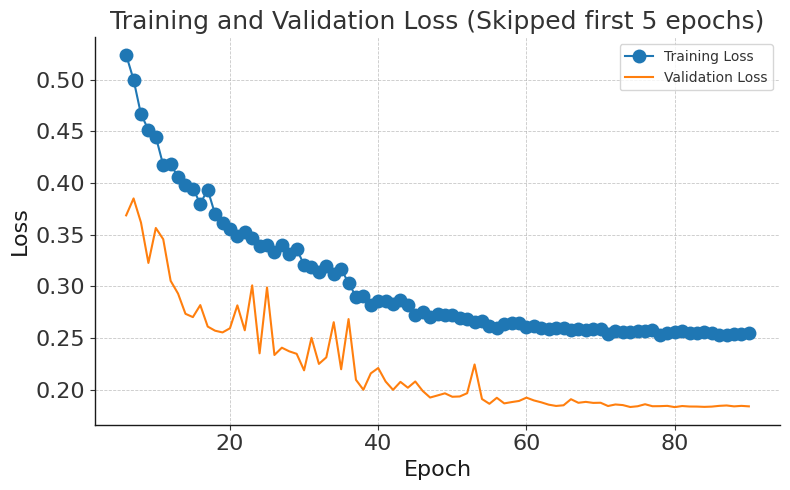

In [11]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

else:
    # Load model and set to CPU
    model_filename = "nn_model_2025-09-03_50%_regional.pt"  # Replace with actual date if needed
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

### Load model and make predictions:

In [12]:

# Load model and set to CPU
model_filename = "nn_model_2025-07-14_CH_flexible.pt"  # Replace with actual date if needed

loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
    cfg,
    model_filename,
    **{
        **args,
        **param_init
    },
)
loaded_model = loaded_model.set_params(device='cpu')
loaded_model = loaded_model.to('cpu')

In [13]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

In [14]:
# Summary statistics by glacier for detailed analysis
print("\nDetailed Performance Summary by Glacier:")
glacier_stats = grouped_ids.groupby('GLACIER').agg({
    'target': ['count', 'mean', 'std'],
    'pred': ['mean', 'std']
}).round(4)

# Calculate RMSE and MAE per glacier
glacier_rmse = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.sqrt(np.mean((x['target'] - x['pred'])**2))
).round(4)

glacier_mae = grouped_ids.groupby('GLACIER').apply(
    lambda x: np.mean(np.abs(x['target'] - x['pred']))
).round(4)

glacier_r2 = grouped_ids.groupby('GLACIER').apply(
    lambda x: 1 - np.sum((x['target'] - x['pred'])**2) / np.sum((x['target'] - x['target'].mean())**2)
).round(4)

glacier_rho = grouped_ids.groupby('GLACIER').apply(
    lambda x: x['target'].corr(x['pred'])
).round(4)

# Combine all metrics
performance_summary = pd.DataFrame({
    'N_samples': glacier_stats[('target', 'count')],
    'RMSE': glacier_rmse,
    'MAE': glacier_mae,
    'R²': glacier_r2,
    'Pearson': glacier_rho,
    'Target_mean': glacier_stats[('target', 'mean')],
    'Target_std': glacier_stats[('target', 'std')]
}).sort_values('RMSE')

print("Performance by glacier (sorted by RMSE):")
display(performance_summary)


Detailed Performance Summary by Glacier:
Performance by glacier (sorted by RMSE):


,N_samples,RMSE,MAE,R²,Pearson,Target_mean,Target_std
GLACIER,,,,,,,
FR4N01236A02 des Grands Montets,11,0.4217,0.3307,0.5002,0.7129,1.1582,0.6256
FR4N01146D09+E06 Gebroulaz,1285,0.6263,0.4659,0.8764,0.9373,-0.3350,1.7820
FR4N01236A07 de Talefre,272,0.7074,0.5253,0.8877,0.9488,-0.7821,2.1151
FR4N01236A01 Leschaux,302,0.7694,0.5715,0.9105,0.9656,-1.2866,2.5769
FR4N01235A08 dArgentiere,2513,0.9092,0.7045,0.8417,0.9368,-0.8150,2.2854
FR4N01236A01 Mer de Glace/Geant,1185,1.0015,0.7173,0.9302,0.9682,-2.0811,3.7912
FR4N01162B09+154D03 de Saint Sorlin,2163,1.0189,0.7456,0.6793,0.9145,-0.4864,1.7997
FR4N01083B21 Blanc,267,1.8530,1.6898,-0.3451,0.8598,-0.8005,1.6007
FR4N01163A02 de Sarennes 1,68,3.6081,2.6888,-1.8672,0.7864,-0.2054,2.1467


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Filter the data for the specified glacier and year
data_2023 = grouped_ids[(grouped_ids['GLACIER'] == 'FR4N01083B21 Blanc') & (grouped_ids['YEAR'] == 2023)]

# Filter the data for the same glacier but all other years
data_other_years = grouped_ids[(grouped_ids['GLACIER'] == 'FR4N01083B21 Blanc') & (grouped_ids['YEAR'] != 2023)]

data_all_years = grouped_ids[grouped_ids['GLACIER'] == 'FR4N01083B21 Blanc']

# Calculate RMSE for 2023
rmse_2023 = np.sqrt(mean_squared_error(data_2023['target'], data_2023['pred']))

# Calculate RMSE for all other years
rmse_other_years = np.sqrt(mean_squared_error(data_other_years['target'], data_other_years['pred']))

rmse_all_years = np.sqrt(mean_squared_error(data_all_years['target'], data_all_years['pred']))

# Print the results
print(f"RMSE for 2023: {rmse_2023}")
print(f"RMSE for all other years: {rmse_other_years}")
print(f"RMSE for all years: {rmse_all_years}")

In [20]:
# Set pandas to display all rows
pd.set_option('display.max_rows', None)

# Display all rows where GLACIER is 'FR4N01083B21 Blanc'
display(grouped_ids[grouped_ids['GLACIER'] == 'FR4N01083B21 Blanc'])

display(grouped_ids[(grouped_ids['GLACIER'] == 'FR4N01083B21 Blanc') & (grouped_ids['YEAR'] == '2023')])

# Reset pandas display options to default if needed
pd.reset_option('display.max_rows')

display(grouped_ids[abs(grouped_ids['target'] - grouped_ids['pred']) > 4])

,target,ID,pred,PERIOD,GLACIER,YEAR


,target,ID,pred,PERIOD,GLACIER,YEAR


,target,ID,pred,PERIOD,GLACIER,YEAR


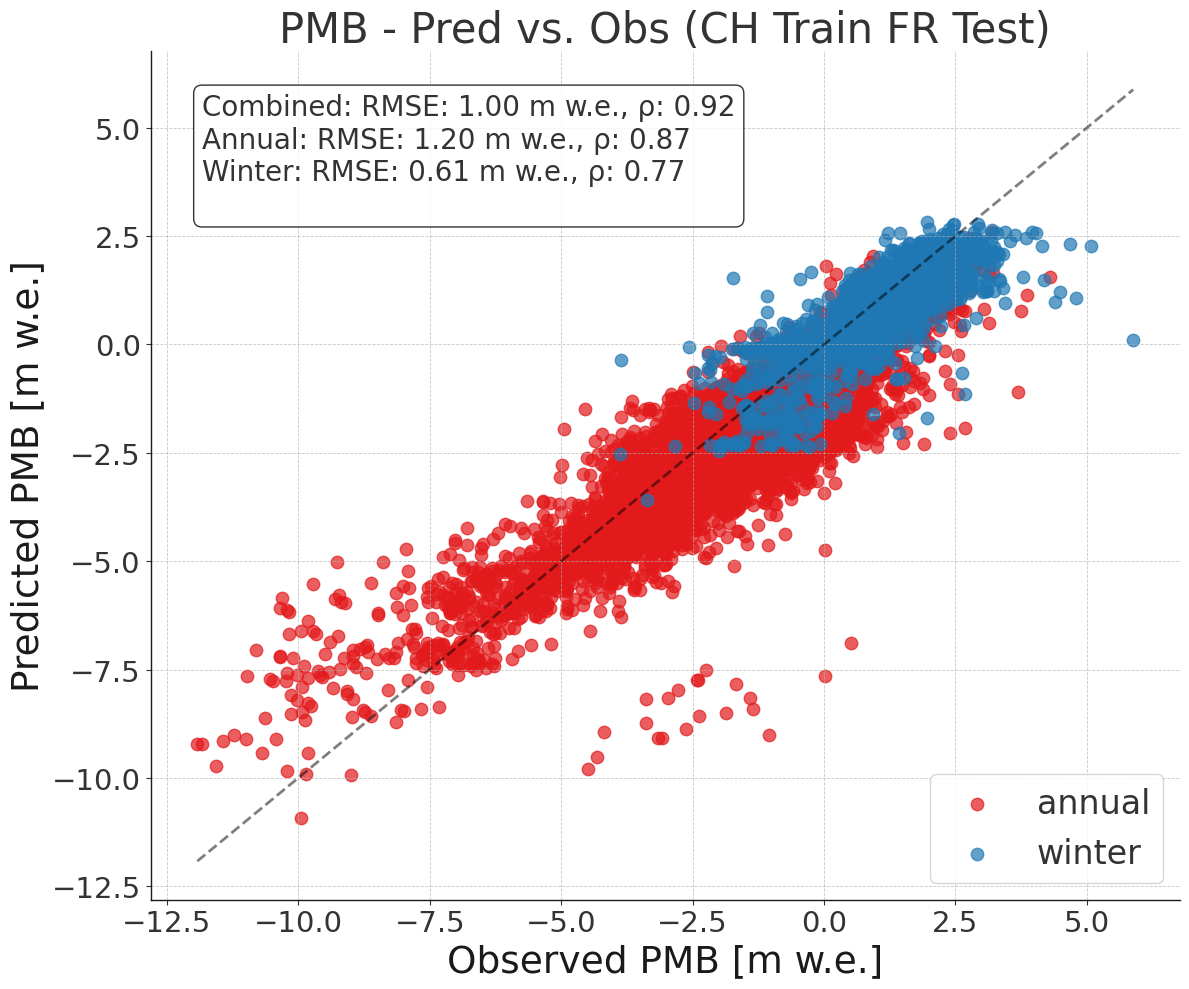

In [15]:
PlotPredictionsCombined_NN(grouped_ids, region_name='CH Train FR Test')

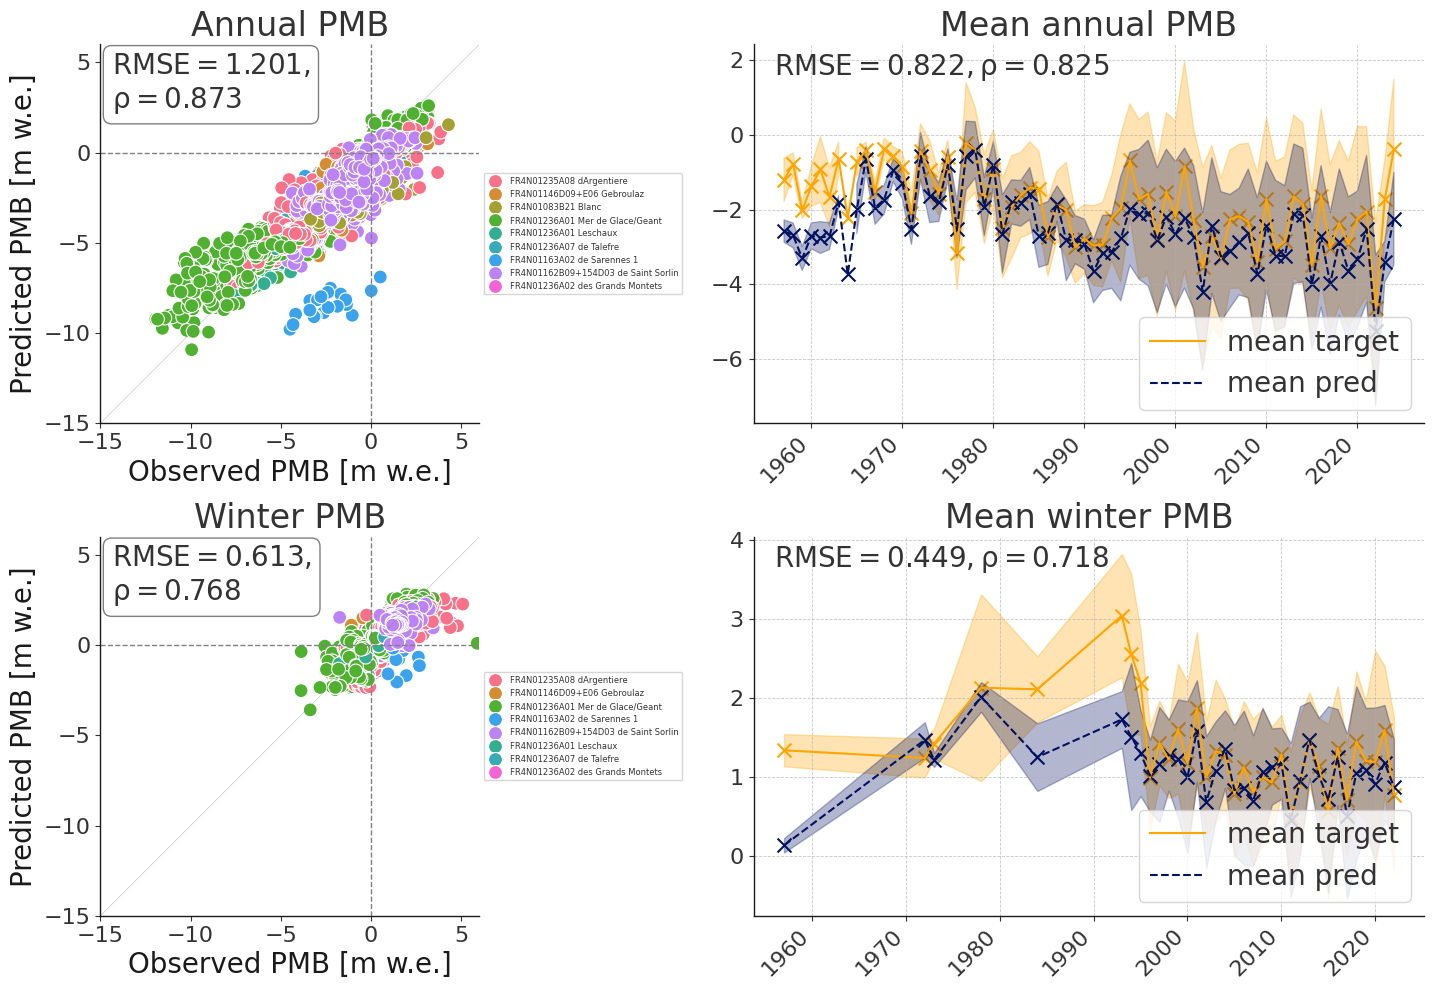

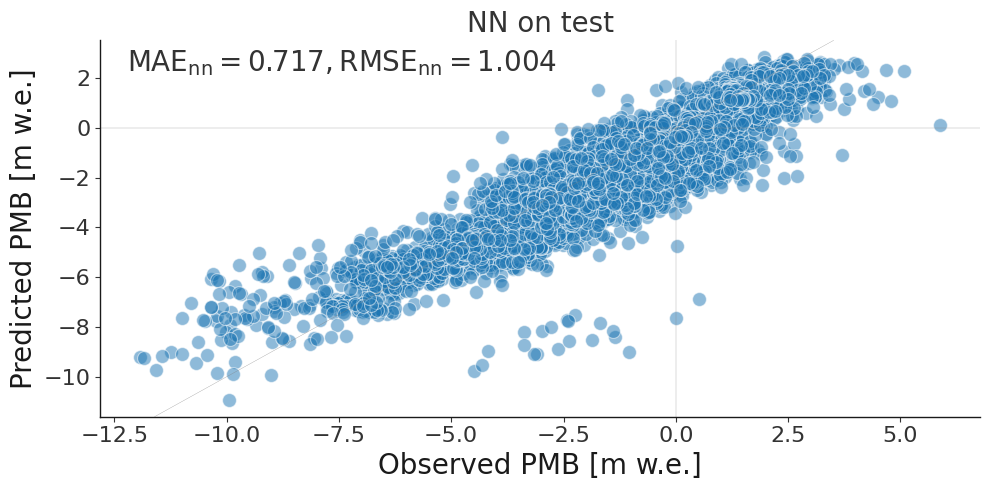

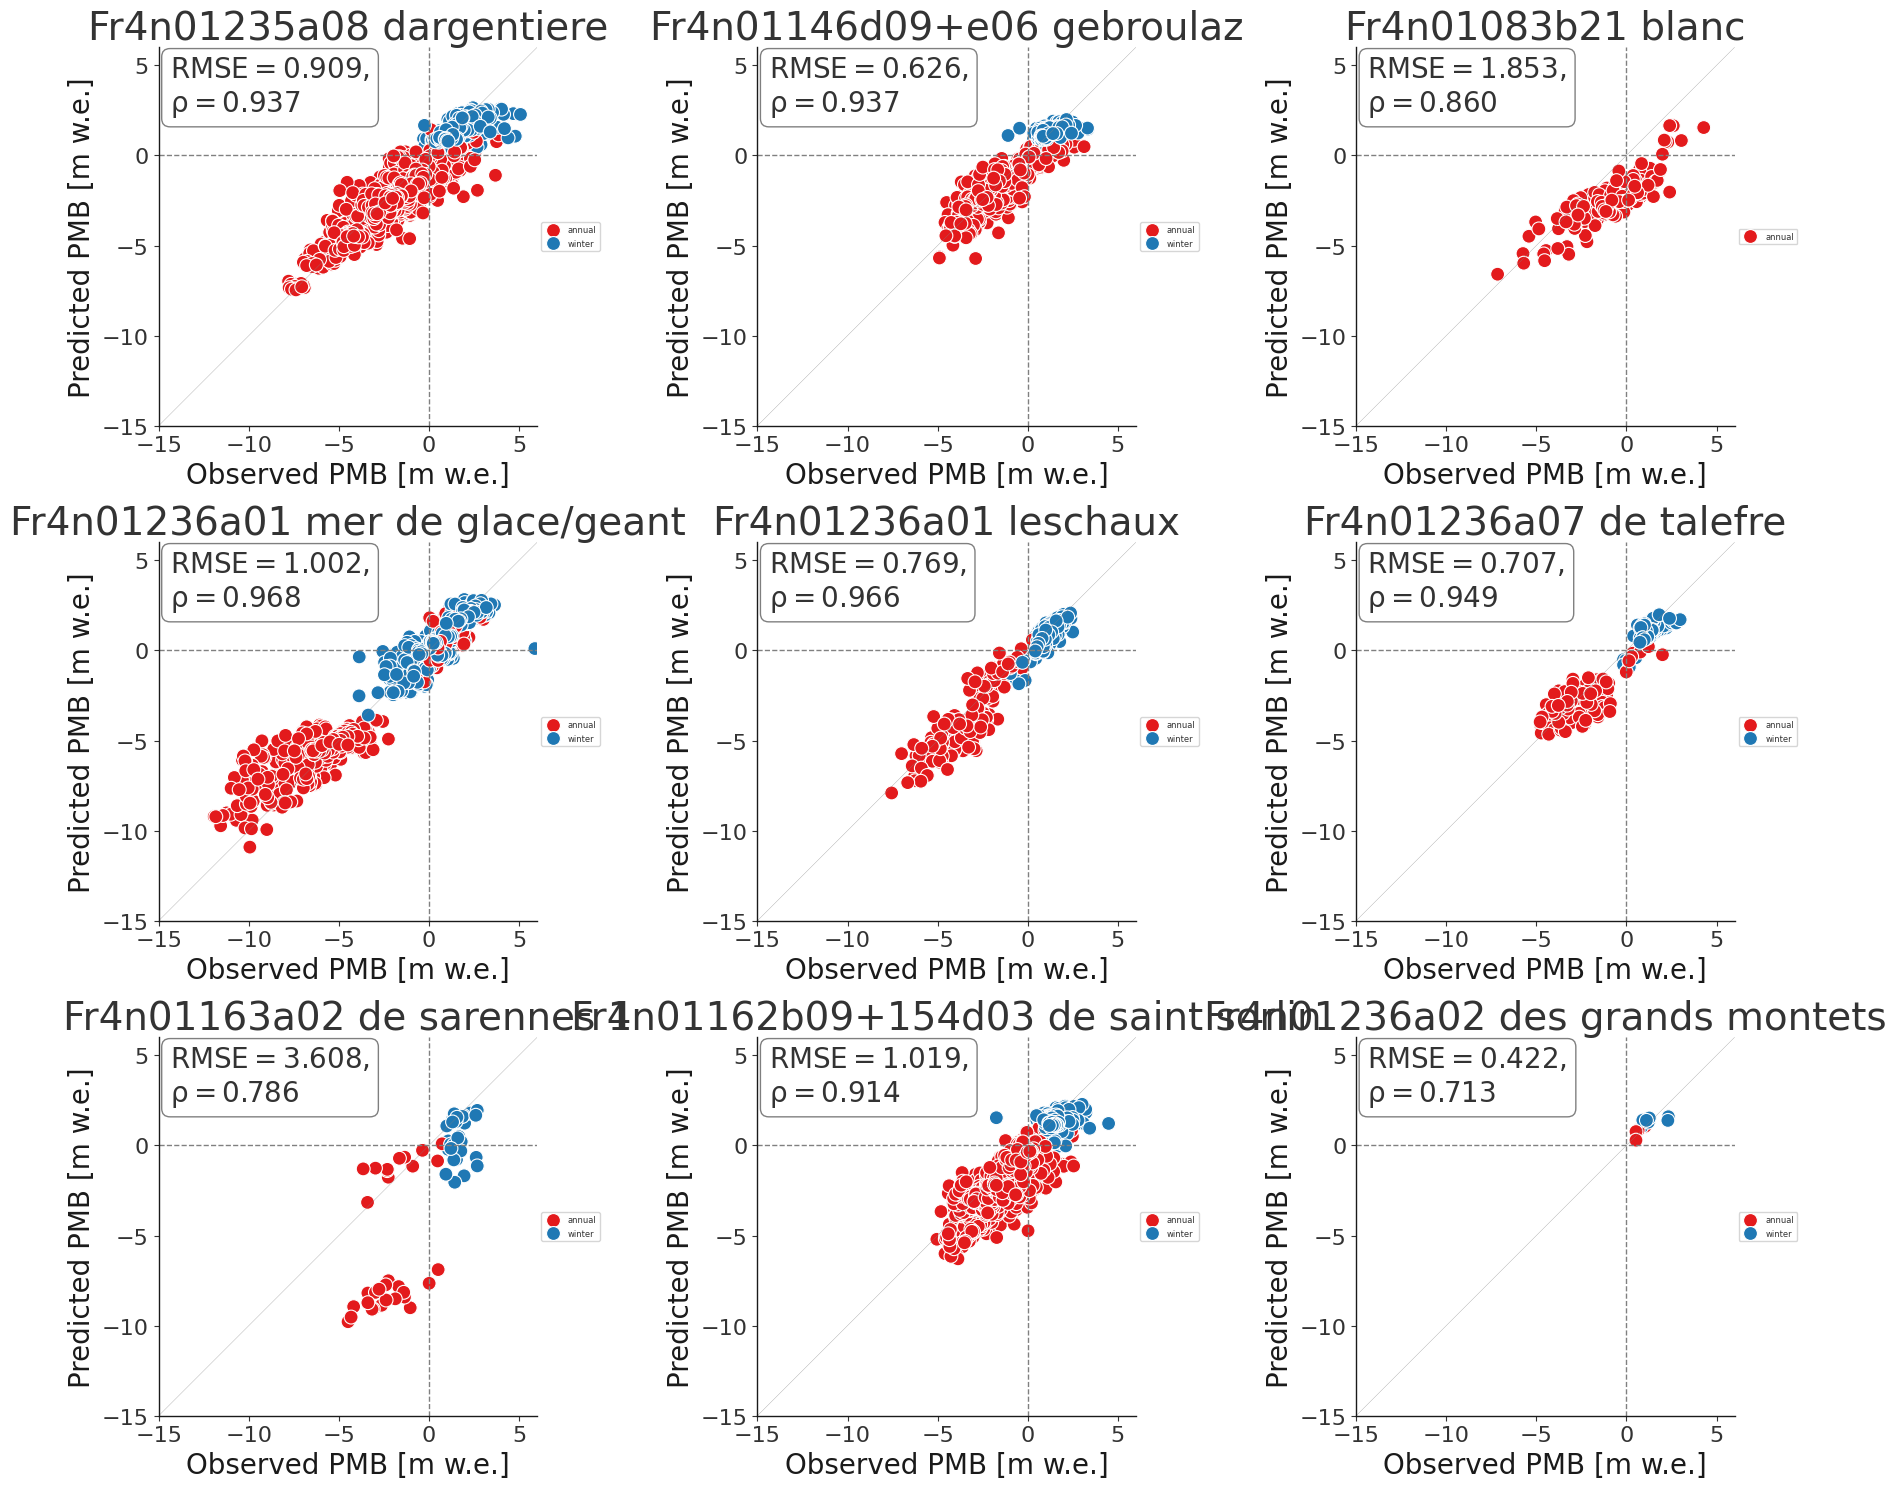

In [17]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [ ]:
# DANN components: Gradient Reversal, network, regressor wrapper, and dataset bindings
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from skorch.utils import to_tensor
import massbalancemachine as mbm
from pathlib import Path

# Gradient Reversal Layer
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

class GradReverse(nn.Module):
    def __init__(self, lambda_=1.0):
        super().__init__()
        self.lambda_ = lambda_
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

class DANNNetwork(nn.Module):
    """
    Feature extractor identical to FlexibleNetwork's trunk, with two heads:
    - Regressor head for SMB (label)
    - Domain classifier head (binary)
    """
    def __init__(self, input_dim, hidden_layers, dropout=0.2, use_batchnorm=False, domain_hidden=64, grl_lambda=1.0):
        super().__init__()
        layers = []
        current_dim = input_dim
        if not isinstance(dropout, list):
            dropout = [dropout] * len(hidden_layers)
        for hidden_dim, drop_rate in zip(hidden_layers, dropout):
            layers.append(nn.Linear(current_dim, hidden_dim))
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(drop_rate))
            current_dim = hidden_dim
        # trunk outputs the last hidden representation
        self.feature_extractor = nn.Sequential(*layers)
        # heads
        self.regressor = nn.Linear(current_dim, 1)
        self.grl = GradReverse(lambda_=grl_lambda)
        self.domain_classifier = nn.Sequential(
            nn.Linear(current_dim, domain_hidden),
            nn.ReLU(),
            nn.Dropout(dropout[-1] if isinstance(dropout, list) else dropout),
            nn.Linear(domain_hidden, 1),  # logits
        )

    def forward(self, x):
        h = self.feature_extractor(x)
        y_pred = self.regressor(h)
        d_logits = self.domain_classifier(self.grl(h))
        return y_pred, d_logits

# Dataset that yields domain labels padded per ID to match monthly padding
class DomainTargetDataset(torch.utils.data.Dataset):
    def __init__(self, aggregated_dataset):
        self.base = aggregated_dataset
        self.meta_has_domain = 'DOMAIN' in self.base.metadataColumns
        if not self.meta_has_domain:
            # fallback: try to read from features
            assert 'DOMAIN' in self.base.cfg.featureColumns, "DOMAIN must be in metadata or featureColumns"
            self.domain_feat_idx = self.base.cfg.featureColumns.index('DOMAIN')
        else:
            self.domain_idx = self.base.metadataColumns.index('DOMAIN')
    def __len__(self):
        return len(self.base)
    def __getitem__(self, index):
        ind = self.base._getInd(index)
        if self.meta_has_domain:
            dval = self.base.metadata[ind[0]][self.domain_idx]
        else:
            dval = self.base.features[ind[0], self.domain_feat_idx]
        dpad = np.empty(self.base.maxConcatNb, dtype=np.float32)
        dpad.fill(np.nan)
        dpad[:len(ind)] = dval
        return dpad

# Binding that returns (X, (y, d)) so y_true in get_loss can contain both
class CombinedTargetBinding(torch.utils.data.Dataset):
    def __init__(self, X_slice, y_slice, d_dataset):
        self.X = X_slice
        self.y = y_slice
        self.d = d_dataset
        assert len(self.X) == len(self.y) == len(self.d)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], (self.y[idx], self.d[idx])

# Skorch regressor that adds domain-adversarial loss on top of the SMB loss
class CustomDANNRegressor(mbm.models.CustomNeuralNetRegressor):
    def __init__(self, cfg, *args, dan_lambda=0.1, **kwargs):
        super().__init__(cfg, *args, **kwargs)
        self.dan_lambda = dan_lambda
        self._last_domain_logits = None

    def infer(self, x, **fit_params):
        x = to_tensor(x, device=self.device)
        if len(x.shape) == 1:
            x = x[None]
        x, indNonNan = self._unpack_inp(x)
        if self.modelDtype is not None:
            x = x.type(self.modelDtype)
        outputs = self.module_(x, **fit_params)
        if isinstance(outputs, tuple):
            y_monthly, d_monthly = outputs
            y_packed = self._pack_out(y_monthly, indNonNan)
            d_packed = self._pack_out(d_monthly, indNonNan)
            self._last_domain_logits = d_packed
            return y_packed
        else:
            return self._pack_out(outputs, indNonNan)

    def get_loss(self, y_pred, y_true, X=None, training=False):
        # y_true can be (label_pad, domain_pad) from CombinedTargetBinding
        if isinstance(y_true, (tuple, list)) and len(y_true) == 2:
            y_true_labels, y_true_domain = y_true
        else:
            y_true_labels, y_true_domain = y_true, None

        # Label loss (same as base implementation)
        loss = 0.0
        cnt = 0
        for yi_pred, yi_true in zip(y_pred, y_true_labels):
            valid = ~torch.isnan(yi_pred)
            if valid.any():
                pred_sum = yi_pred[valid].sum()
                true_mean = yi_true[valid].mean()
                loss = loss + (pred_sum - true_mean) ** 2
                cnt += 1
        label_loss = loss / max(cnt, 1)

        # Domain loss (optional during training)
        """"
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits
            mask = ~torch.isnan(y_true_domain)
            if mask.any():
                domain_loss = F.binary_cross_entropy_with_logits(d_logits[mask], y_true_domain[mask].float())
        """
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean, otherwise IDs with longer months have higher domain loss
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # shape: [batch, max_months] (or [batch, max_months, 1])
            per_id_losses = []
            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                # squeeze trailing dim if present
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                # mask valid months
                mask = ~torch.isnan(d_true_row) # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    per_id_losses.append(loss_i)

            if len(per_id_losses) > 0:
                domain_loss = torch.stack(per_id_losses).mean()  # mean over IDs
        """
        # Domain loss a bit more complicated due to Per-ID mean and then batch mean for each domain
        # otherwise IDs with longer months have higher domain loss and CH domain loss with more data is exaggerated
        domain_loss = torch.tensor(0.0, device=y_pred.device)
        if training and (y_true_domain is not None) and (self._last_domain_logits is not None):
            d_logits = self._last_domain_logits  # [batch_ids, max_months(,1)]
            per_id_losses_ch, per_id_losses_nor = [], []

            for d_log_row, d_true_row in zip(d_logits, y_true_domain):
                if d_log_row.ndim > 1:
                    d_log_row = d_log_row.squeeze(-1)

                mask = ~torch.isnan(d_true_row)  # Select valid months per ID, NaN padding months are False
                if mask.any():
                    loss_i = F.binary_cross_entropy_with_logits(
                        d_log_row[mask],
                        d_true_row[mask].float(),
                        reduction='mean',  # mean over valid months for this ID
                    )
                    # domain for this ID (same across valid months)
                    dom_i = int(d_true_row[mask][0].item())  # 0=CH, 1=NOR
                    (per_id_losses_ch if dom_i == 0 else per_id_losses_nor).append(loss_i)

            parts = []
            if len(per_id_losses_ch) > 0:
                parts.append(torch.stack(per_id_losses_ch).mean())
            if len(per_id_losses_nor) > 0:
                parts.append(torch.stack(per_id_losses_nor).mean())
            if len(parts) > 0:
                domain_loss = torch.stack(parts).mean()

        return label_loss + self.dan_lambda * domain_loss

    @staticmethod
    def load_model(cfg, fname: str, *args, **kwargs):
        """Loads a pre-trained DANN model from a file."""
        model = CustomDANNRegressor(cfg, *args, **kwargs)
        model.initialize()
        models_dir = Path("./models")
        model.load_params(f_params=models_dir / fname)
        return model

params_dann = {
    'lr': 0.001,
    'batch_size': 128,
    'optimizer': torch.optim.Adam,
    'optimizer__weight_decay': 1e-05,
    'module__hidden_layers': [128, 128, 64, 32],
    'module__dropout': 0.2,
    'module__use_batchnorm': True,
    'module__domain_hidden': 64,
    'module__grl_lambda': 1.0,
}

# Use DANN network
args_dann = {
    'module': DANNNetwork,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__dropout': params_dann['module__dropout'],
    'module__hidden_layers': params_dann['module__hidden_layers'],
    'module__use_batchnorm': params_dann['module__use_batchnorm'],
    'module__domain_hidden': params_dann['module__domain_hidden'],
    'module__grl_lambda': params_dann['module__grl_lambda'],
    'train_split': my_train_split,
    'batch_size': params_dann['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params_dann['lr'],
    'max_epochs': 200,
    'optimizer': params_dann['optimizer'],
    'optimizer__weight_decay': params_dann['optimizer__weight_decay'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}

Loading Regional Baseline: nn_model_2025-08-24_5-10%_3rd_try_regional_baseline.pt


Loading CH and Regional Baseline: nn_model_2025-08-24_5-10%_CH_and_5-10%_baseline_only_FR_val.pt
Loading Fine-tuning: nn_model_finetuned_2025-08-24_5-10%__3rd_try_fine_tuning_lr0.0005_epoch_10.pt
Loading Batchnorm Unfrozen: nn_model_finetuned_2025-08-24_5-10%_3rd_try_batchnorm_unfrozen_linear_frozen_lr0.05_epoch200.pt
Loading DANN: dann_model_2025-08-24_5-10%_lamba0_05_mean_domainloss_even_domainloss_only_FR_val_50_50epochsplit.pt


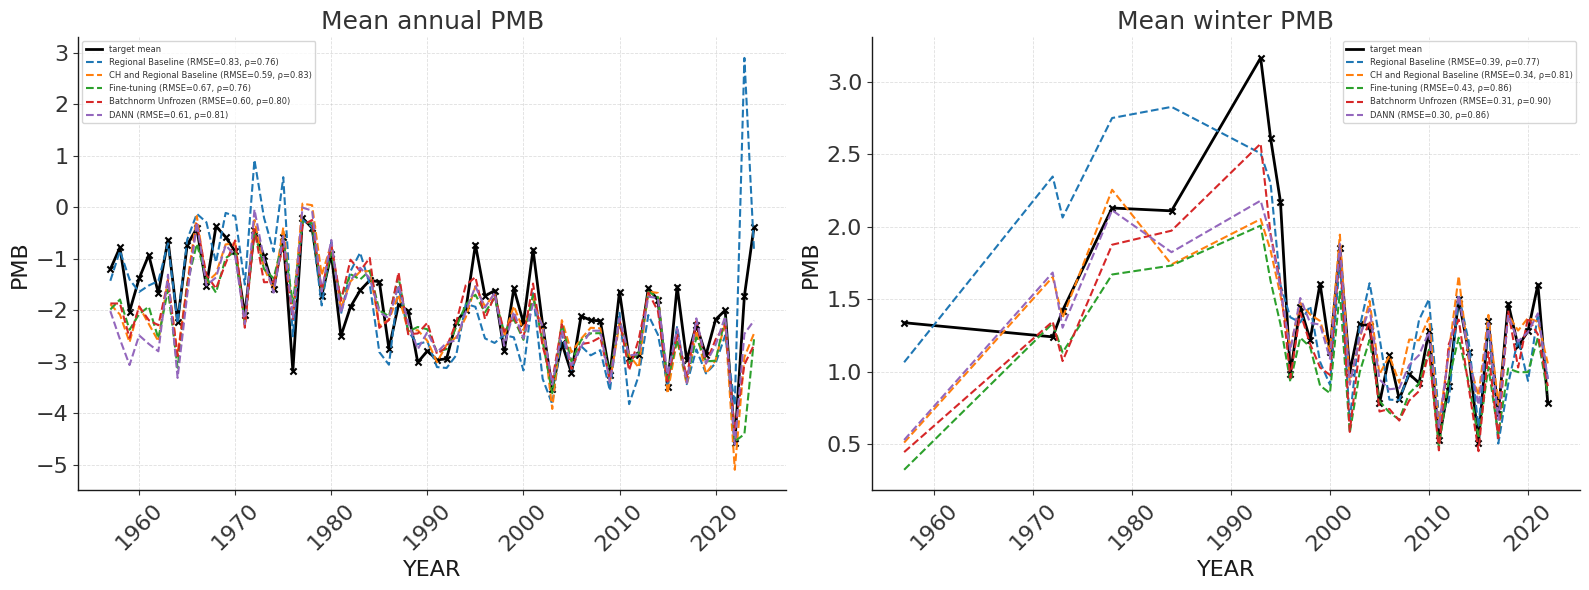

In [15]:
def plot_mean_pmb_multi(models_grouped, title_prefix='Mean PMB'):
    """
    models_grouped: dict[str -> DataFrame] where each DF has columns
      ['target','ID','pred','PERIOD','GLACIER','YEAR'] as returned by loader above.
    """
    # Use the first model’s DF as reference for ground-truth shading (same targets for all)
    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()

    # Prepare figure
    fig, (ax_ann, ax_win) = plt.subplots(1, 2, figsize=(16, 6))
    ax_ann.set_title('Mean annual PMB', fontsize=18)
    ax_win.set_title('Mean winter PMB', fontsize=18)

    # Colors for models
    palette = sns.color_palette("tab10", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho

    # Helper to plot one panel (annual or winter)
    def _plot_panel(ax, period_name):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())

        # Ground-truth mean line (black)
        tgt_mean = df_period.groupby('YEAR')['target'].mean().reindex(years)
        ax.plot(years, tgt_mean, color="black", label="target mean", linewidth=2)
        ax.scatter(years, tgt_mean, color="black", marker='x', s=20)

        # Plot each model’s mean prediction per year and compute metrics (per period)
        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean().reindex(years)

            # Compute RMSE and Pearson r for this period (use per-ID means)
            metrics_df = pd.DataFrame({
                'YEAR': years,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            ).rename(columns={'target': 'target'})
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, \u03C1={np.nan_to_num(rho):.2f})"
            ax.plot(years, pred_mean, label=label_with_metrics,
                    color=label_to_color.get(label, None), linestyle='--')
            #ax.scatter(years, pred_mean, color=label_to_color.get(label, None), s=15)

        ax.set_xlabel('YEAR')
        ax.set_ylabel('PMB')
        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(fontsize=6, loc='best')

    _plot_panel(ax_ann, 'annual')
    _plot_panel(ax_win, 'winter')

    plt.tight_layout()
    plt.show()


base = grouped_ids[['ID', 'target', 'PERIOD', 'GLACIER', 'YEAR']].copy()

# List models (optionally mix NN and DANN). Provide up to 5.

#5-10%
models = [
    #('CH Baseline',  'nn_model_2025-07-14_CH_flexible.pt', mbm.models.CustomNeuralNetRegressor),
    ('Regional Baseline',  'nn_model_2025-08-24_5-10%_3rd_try_regional_baseline.pt', mbm.models.CustomNeuralNetRegressor),
    ('CH and Regional Baseline',  'nn_model_2025-08-24_5-10%_CH_and_5-10%_baseline_only_FR_val.pt', mbm.models.CustomNeuralNetRegressor),
    ('Fine-tuning',  'nn_model_finetuned_2025-08-24_5-10%__3rd_try_fine_tuning_lr0.0005_epoch_10.pt', mbm.models.CustomNeuralNetRegressor),
    ('Batchnorm Unfrozen',  'nn_model_finetuned_2025-08-24_5-10%_3rd_try_batchnorm_unfrozen_linear_frozen_lr0.05_epoch200.pt', mbm.models.CustomNeuralNetRegressor),
    ('DANN',      'dann_model_2025-08-24_5-10%_lamba0_05_mean_domainloss_even_domainloss_only_FR_val_50_50epochsplit.pt', CustomDANNRegressor),
]

device = 'cpu'
# Build loader args for plain NN (FlexibleNetwork) and DANN (DANNNetwork)
nn_loader_args = {**args, **param_init}
try:
    _ = DANNNetwork  # ensure defined (from the DANN cell below)
    dann_loader_args = {
        **{
            **args,
            'module': DANNNetwork,
            'module__domain_hidden': params.get('module__domain_hidden', 64),
            'module__grl_lambda': params.get('module__grl_lambda', 1.0),
        },
        'dan_lambda': 0.05,  # inference-only, safe if different from train
        **param_init,
    }
except NameError:
    dann_loader_args = None  # will raise a clear error if DANN is requested

models_grouped = {}

for label, fname, model_cls in models:
    print(f'Loading {label}: {fname}')
    # Pick correct architecture for this checkpoint
    if model_cls.__name__ == 'CustomDANNRegressor':
        if dann_loader_args is None:
            raise NameError("DANNNetwork not available. Run the DANN components cell before loading DANN models.")
        mdl = model_cls.load_model(cfg, fname, **dann_loader_args)
    else:
        mdl = model_cls.load_model(cfg, fname, **nn_loader_args)

    mdl = mdl.set_params(device=device).to(device)

    # Predict aggregated by measurement ID using the same dataset_test
    y_pred_agg = mdl.aggrPredict(dataset_test[0])

    assert len(y_pred_agg) == len(base), f'Length mismatch for {label}'
    gdf = base.copy()
    gdf['pred'] = y_pred_agg
    models_grouped[label] = gdf

# Plot mean annual and mean winter PMB for all models together
plot_mean_pmb_multi(models_grouped)

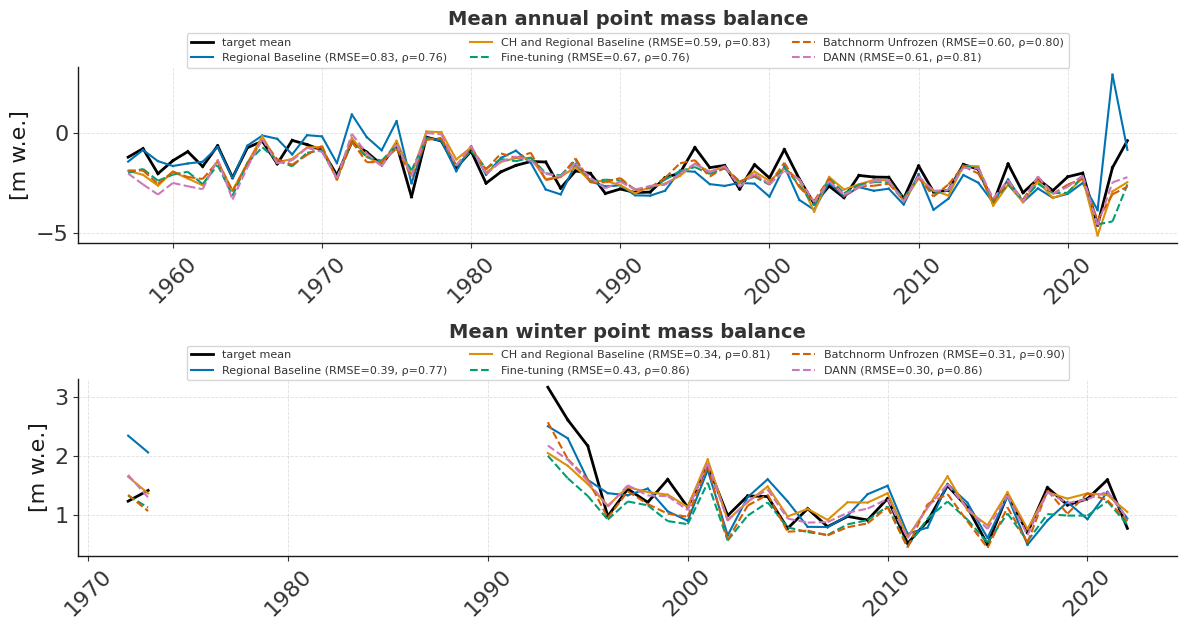

In [16]:
def plot_mean_pmb_multi_fixed_lines(models_grouped, title_prefix='Mean PMB'):

    # Use the first model's DF as reference for ground-truth shading (same targets for all)
    first_label = next(iter(models_grouped))
    df_ref = models_grouped[first_label].copy()

    # Prepare figure
    fig, (ax_ann, ax_win) = plt.subplots(2, 1, figsize=(12, 8))  # Increased height more

    # Add titles to each subplot with more padding
    ax_ann.set_title('Mean annual point mass balance', fontsize=14, fontweight='bold', pad=30)
    ax_win.set_title('Mean winter point mass balance', fontsize=14, fontweight='bold', pad=30)

    # Colors for models
    palette = sns.color_palette("colorblind", n_colors=len(models_grouped))
    label_to_color = {label: palette[i] for i, label in enumerate(models_grouped.keys())}

    # Define line styles for regional and transfer learning models
    regional_models = ['Regional Baseline', 'CH and Regional Baseline']
    transfer_models = ['Fine-tuning', 'Batchnorm Unfrozen', 'DANN']
    line_styles = {model: '-' for model in regional_models}  # Solid lines for regional models
    line_styles.update({model: '--' for model in transfer_models})  # Dashed lines for transfer models

    def _compute_metrics(df_y):
        valid = df_y[['pred', 'target']].dropna()
        if len(valid) == 0:
            return np.nan, np.nan
        y_pred = valid['pred'].values
        y_true = valid['target'].values
        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        rho = np.corrcoef(y_pred, y_true)[0, 1] if y_pred.size > 1 else np.nan
        return rmse, rho

    # Helper to plot one panel (annual or winter)
    def _plot_panel(ax, period_name):
        df_period = df_ref[df_ref['PERIOD'] == period_name].copy()
        years = np.sort(df_period['YEAR'].unique())

        # Ground-truth mean line (black) - only connect consecutive years
        tgt_mean = df_period.groupby('YEAR')['target'].mean()
        available_years = tgt_mean.index.values
        available_values = tgt_mean.values
        
        # Plot line segments only between consecutive years with x markers
        target_line_plotted = False
        for i in range(len(available_years) - 1):
            if available_years[i+1] - available_years[i] == 1:  # consecutive years
                if not target_line_plotted:
                    # First line segment gets the label with line and x markers
                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6,
                           label="target mean")
                    target_line_plotted = True
                else:
                    # Subsequent segments without label but with x markers
                    ax.plot([available_years[i], available_years[i+1]], 
                           [available_values[i], available_values[i+1]], 
                           color="black", linewidth=2, marker='x', markersize=6)
        
        # If no line was plotted (all isolated points), plot isolated points with x markers
        if not target_line_plotted:
            ax.plot(available_years, available_values, color="black", marker='x', markersize=6,
                   linestyle='None', label="target mean")

        # Plot each model's mean prediction per year and compute metrics (per period)
        for label, gdf in models_grouped.items():
            gdf_p = gdf[gdf['PERIOD'] == period_name].copy()
            pred_mean = gdf_p.groupby('YEAR')['pred'].mean()

            # Compute RMSE and R² for this period (use per-ID means)
            metrics_df = pd.DataFrame({
                'YEAR': pred_mean.index,
                'pred': pred_mean.values,
            }).merge(
                df_period.groupby('YEAR')['target'].mean().reset_index(), on='YEAR', how='left'
            )
            rmse, rho = _compute_metrics(metrics_df)

            label_with_metrics = f"{label} (RMSE={np.nan_to_num(rmse):.2f}, \u03C1={np.nan_to_num(rho):.2f})"
            
            # Plot line segments only between consecutive years
            pred_years = pred_mean.index.values
            pred_values = pred_mean.values
            
            label_added = False  # Track if we've added the label for this model
            
            for i in range(len(pred_years) - 1):
                if pred_years[i+1] - pred_years[i] == 1:  # consecutive years
                    ax.plot([pred_years[i], pred_years[i+1]], 
                           [pred_values[i], pred_values[i+1]], 
                           color=label_to_color.get(label, None), 
                           linestyle=line_styles.get(label, '-'),
                           label=label_with_metrics if not label_added else "")
                    label_added = True
            
            # If no consecutive years were found, add a dummy line for the legend
            if not label_added and len(pred_years) > 0:
                ax.plot([], [], 
                       color=label_to_color.get(label, None), 
                       linestyle=line_styles.get(label, '-'),
                       label=label_with_metrics)

        ax.grid(True, linestyle='--', alpha=0.4)
        ax.tick_params(axis='x', rotation=45)

    _plot_panel(ax_ann, 'annual')
    _plot_panel(ax_win, 'winter')

    # Add legends with much more spacing to avoid overlap
    ax_ann.legend(fontsize=8, loc='upper center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.22))
    ax_win.legend(fontsize=8, loc='upper center', ncol=3, frameon=True, bbox_to_anchor=(0.5, 1.22))

    # Add y-axis labels
    ax_ann.set_ylabel('[m w.e.]')
    ax_win.set_ylabel('[m w.e.]')

    # Adjust layout to make space for the legends and titles
    plt.tight_layout(rect=(0, 0, 1, 0.8))  # Much more space at top
    plt.show()

plot_mean_pmb_multi_fixed_lines(models_grouped)

In [17]:
def create_model_comparison_table(models_grouped, periods=['annual', 'winter', 'combined']):
    import pandas as pd
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    # Define the desired order of models
    desired_order = [
        'Regional Baseline',
        'CH and Regional Baseline', 
        'Fine-tuning',
        'Batchnorm Unfrozen',
        'DANN'
    ]
    
    results = []
    
    # Process models in the desired order
    for model_name in desired_order:
        if model_name not in models_grouped:
            continue  # Skip if model not found
            
        df = models_grouped[model_name]
        # Filter out summer data (keep only annual and winter)
        df_filtered = df[df['PERIOD'].isin(['annual', 'winter'])].copy()
        
        # Calculate metrics for each period
        for period in periods:
            if period == 'combined':
                # Use all data (annual + winter)
                period_data = df_filtered
                period_label = 'Combined'
            else:
                # Use specific period data
                period_data = df_filtered[df_filtered['PERIOD'] == period]
                period_label = period.capitalize()
            
            if len(period_data) == 0:
                continue
                
            y_true = period_data['target'].values
            y_pred = period_data['pred'].values
            
            # Calculate metrics
            mae = mean_absolute_error(y_true, y_pred)
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            r2 = r2_score(y_true, y_pred)
            rho = np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
            
            results.append({
                'Model': model_name,
                'Period': period_label,
                'N_samples': len(period_data),
                'MAE': mae,
                'RMSE': rmse,
                'ρ': rho,
                'R²': r2,
                
            })
    
    # Create DataFrame
    results_df = pd.DataFrame(results)
    
    # Pivot table for better display
    metrics = ['N_samples', 'MAE', 'RMSE', 'ρ', 'R²']

    # Create a multi-index table
    pivot_tables = []
    for metric in metrics:
        pivot = results_df.pivot(index='Model', columns='Period', values=metric)
        pivot.name = metric
        pivot_tables.append(pivot)
    
    # Combine all metrics into one table with multi-level columns
    combined_table = pd.concat(pivot_tables, axis=1, keys=metrics)
    
    # Reorder the index (models) to maintain desired order
    combined_table = combined_table.reindex(desired_order)
    
    # Reorder columns to have Combined, Annual, Winter for each metric
    if 'Combined' in combined_table.columns.get_level_values(1):
        period_order = ['Combined', 'Annual', 'Winter']
    else:
        period_order = ['Annual', 'Winter']
    
    # Reorder columns
    new_columns = []
    for metric in metrics:
        for period in period_order:
            if (metric, period) in combined_table.columns:
                new_columns.append((metric, period))
    
    combined_table = combined_table[new_columns]
    
    # Round numerical values for better display
    numeric_metrics = ['MAE', 'RMSE', 'ρ', 'R²']
    for metric in numeric_metrics:
        for period in period_order:
            if (metric, period) in combined_table.columns:
                combined_table[(metric, period)] = combined_table[(metric, period)].round(3)
    
    return combined_table

def display_model_comparison_table(models_grouped):
    """
    Display a nicely formatted comparison table for all models.
    """
    table = create_model_comparison_table(models_grouped)
    
    print("="*80)
    print("MODEL PERFORMANCE COMPARISON TABLE")
    print("="*80)
    print()
    
    # Display the table
    print(table.to_string())
    
    print()
    print("Metrics explanation:")
    print("- N_samples: Number of data points")
    print("- MAE: Mean Absolute Error [m w.e.]")
    print("- RMSE: Root Mean Square Error [m w.e.]") 
    print("- R²: Coefficient of determination")
    print("- ρ: Pearson correlation coefficient")
    print("="*80)
    
    return table

# Generate and display the comparison table
comparison_table = display_model_comparison_table(models_grouped)

# Optionally, save to CSV
comparison_table.to_csv('5-10%_model_comparison_fr.csv')

MODEL PERFORMANCE COMPARISON TABLE

                         N_samples                    MAE                   RMSE                      ρ                     R²              
Period                    Combined Annual Winter Combined Annual Winter Combined Annual Winter Combined Annual Winter Combined Annual Winter
Model                                                                                                                                       
Regional Baseline             7413   4447   2966    1.003  1.122  0.824    1.260  1.387  1.040    0.900  0.857  0.680    0.735  0.620 -0.252
CH and Regional Baseline      7413   4447   2966    0.676  0.852  0.411    0.931  1.111  0.563    0.925  0.882  0.805    0.855  0.756  0.633
Fine-tuning                   7413   4447   2966    0.689  0.856  0.439    0.939  1.107  0.603    0.927  0.876  0.793    0.853  0.758  0.578
Batchnorm Unfrozen            7413   4447   2966    0.687  0.870  0.413    0.958  1.145  0.574    0.923  0.873  0.807 

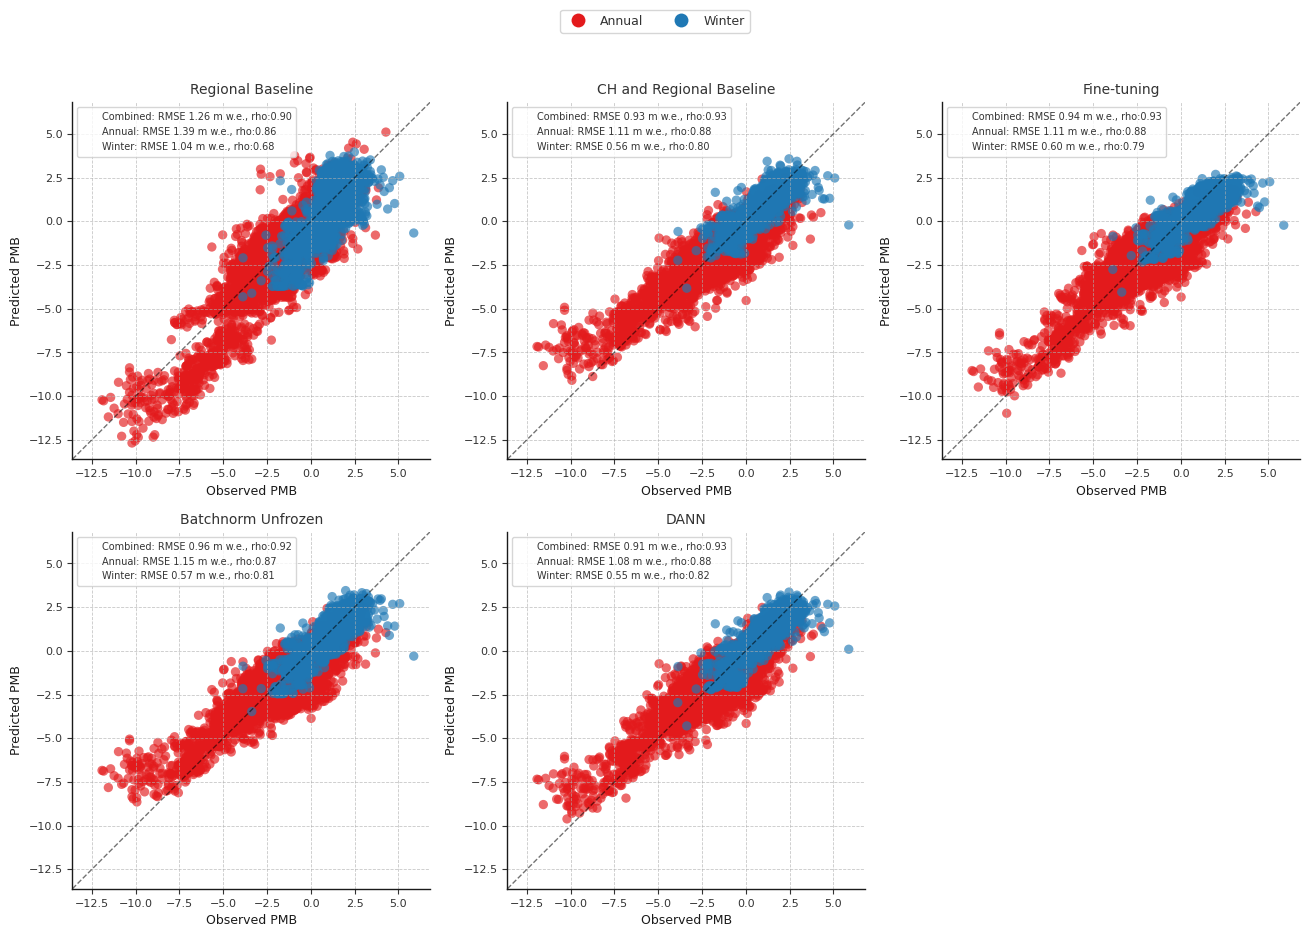

In [18]:
def plot_pred_vs_obs_grid(models_grouped, ncols=3, point_size=45, region_name='CH->FR'):
    """
    Grid of scatter plots (Observed vs Predicted) per model.
    Summer excluded.
    Global legend: Annual points, Winter points.
    Per‑subplot legend: 1:1 line + Combined/Annual/Winter metrics.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.lines import Line2D

    period_colors = {'annual': '#e31a1c', 'winter': '#1f78b4'}
    labels = list(models_grouped.keys())
    n_models = len(labels)
    ncols_eff = min(ncols, n_models)
    nrows = int(np.ceil(n_models / ncols_eff))

    # Global axis limits
    all_targets = np.concatenate([models_grouped[l].target.values for l in labels])
    all_preds   = np.concatenate([models_grouped[l].pred.values   for l in labels])
    gmin = np.nanmin([all_targets.min(), all_preds.min()])
    gmax = np.nanmax([all_targets.max(), all_preds.max()])
    pad = 0.05 * (gmax - gmin)
    gmin -= pad
    gmax += pad

    fig, axes = plt.subplots(nrows, ncols_eff,
                             figsize=(4.4 * ncols_eff, 4.6 * nrows),
                             squeeze=False)
    metrics_all = {}

    for i, label in enumerate(labels):
        r, c = divmod(i, ncols_eff)
        ax = axes[r][c]
        df_plot = models_grouped[label]
        df_plot = df_plot[df_plot.PERIOD.isin(['annual','winter'])].copy()

        # Metrics per period
        panel_metrics = {}
        for period in ['annual','winter']:
            sub = df_plot[df_plot.PERIOD == period]
            if len(sub):
                y_t = sub.target.values
                y_p = sub.pred.values
                rmse = np.sqrt(np.mean((y_p - y_t)**2))
                rho  = np.corrcoef(y_t, y_p)[0,1] if len(sub) > 1 else np.nan
                panel_metrics[period] = (rmse, rho)

        # Combined
        y_t_all = df_plot.target.values
        y_p_all = df_plot.pred.values
        rmse_all = np.sqrt(np.mean((y_p_all - y_t_all)**2))
        rho_all  = np.corrcoef(y_t_all, y_p_all)[0,1] if len(df_plot) > 1 else np.nan
        panel_metrics['combined'] = (rmse_all, rho_all)
        metrics_all[label] = panel_metrics

        # Scatter (no per‑subplot point handles; handled globally)
        for period in ['annual','winter']:
            sub = df_plot[df_plot.PERIOD == period]
            if len(sub):
                ax.scatter(sub.target, sub.pred,
                           s=point_size, alpha=0.65, edgecolor='none',
                           color=period_colors[period])

        # 1:1 line + handle for subplot legend
        ax.plot([gmin,gmax],[gmin,gmax],'k--',linewidth=1,alpha=0.55)
        

        # Metric legend entries
        def metric_handle(name, key):
            rmse, rho = panel_metrics[key]
            return Line2D([],[], linestyle='',
                          label=f"{name}: RMSE {rmse:.2f} m w.e., rho:{rho:.2f}",
                          color='none')

        metric_handles = [
            metric_handle("Combined", 'combined'),
            *( [metric_handle("Annual", 'annual')] if 'annual' in panel_metrics else [] ),
            *( [metric_handle("Winter", 'winter')] if 'winter' in panel_metrics else [] ),
        ]

        ax.set_xlim(gmin,gmax)
        ax.set_ylim(gmin,gmax)
        ax.set_title(label, fontsize=10)
        ax.tick_params(labelsize=8)
        ax.set_xlabel('Observed PMB', fontsize=9)
        ax.set_ylabel('Predicted PMB', fontsize=9)

        # Subplot legend: only 1:1 + metrics
        ax.legend(handles=metric_handles,
                  fontsize=7, loc='upper left',
                  frameon=True, handlelength=1.2, borderpad=0.5)

    # Hide unused axes
    for j in range(n_models, nrows * ncols_eff):
        r, c = divmod(j, ncols_eff)
        axes[r][c].axis('off')

    # Global legend for point types (annual / winter)
    global_point_handles = [
        Line2D([0],[0], marker='o', linestyle='', color=period_colors['annual'],
               label='Annual'),
        Line2D([0],[0], marker='o', linestyle='', color=period_colors['winter'],
               label='Winter')
    ]
    fig.legend(handles=global_point_handles,
               loc='upper center',
               ncol=2,
               frameon=True,
               fontsize=9,
               bbox_to_anchor=(0.5, 1.02))

    plt.tight_layout(rect=(0,0,1,0.95))
    return metrics_all

pred_grid_metrics = plot_pred_vs_obs_grid(models_grouped, ncols=3, region_name='CH->FR')

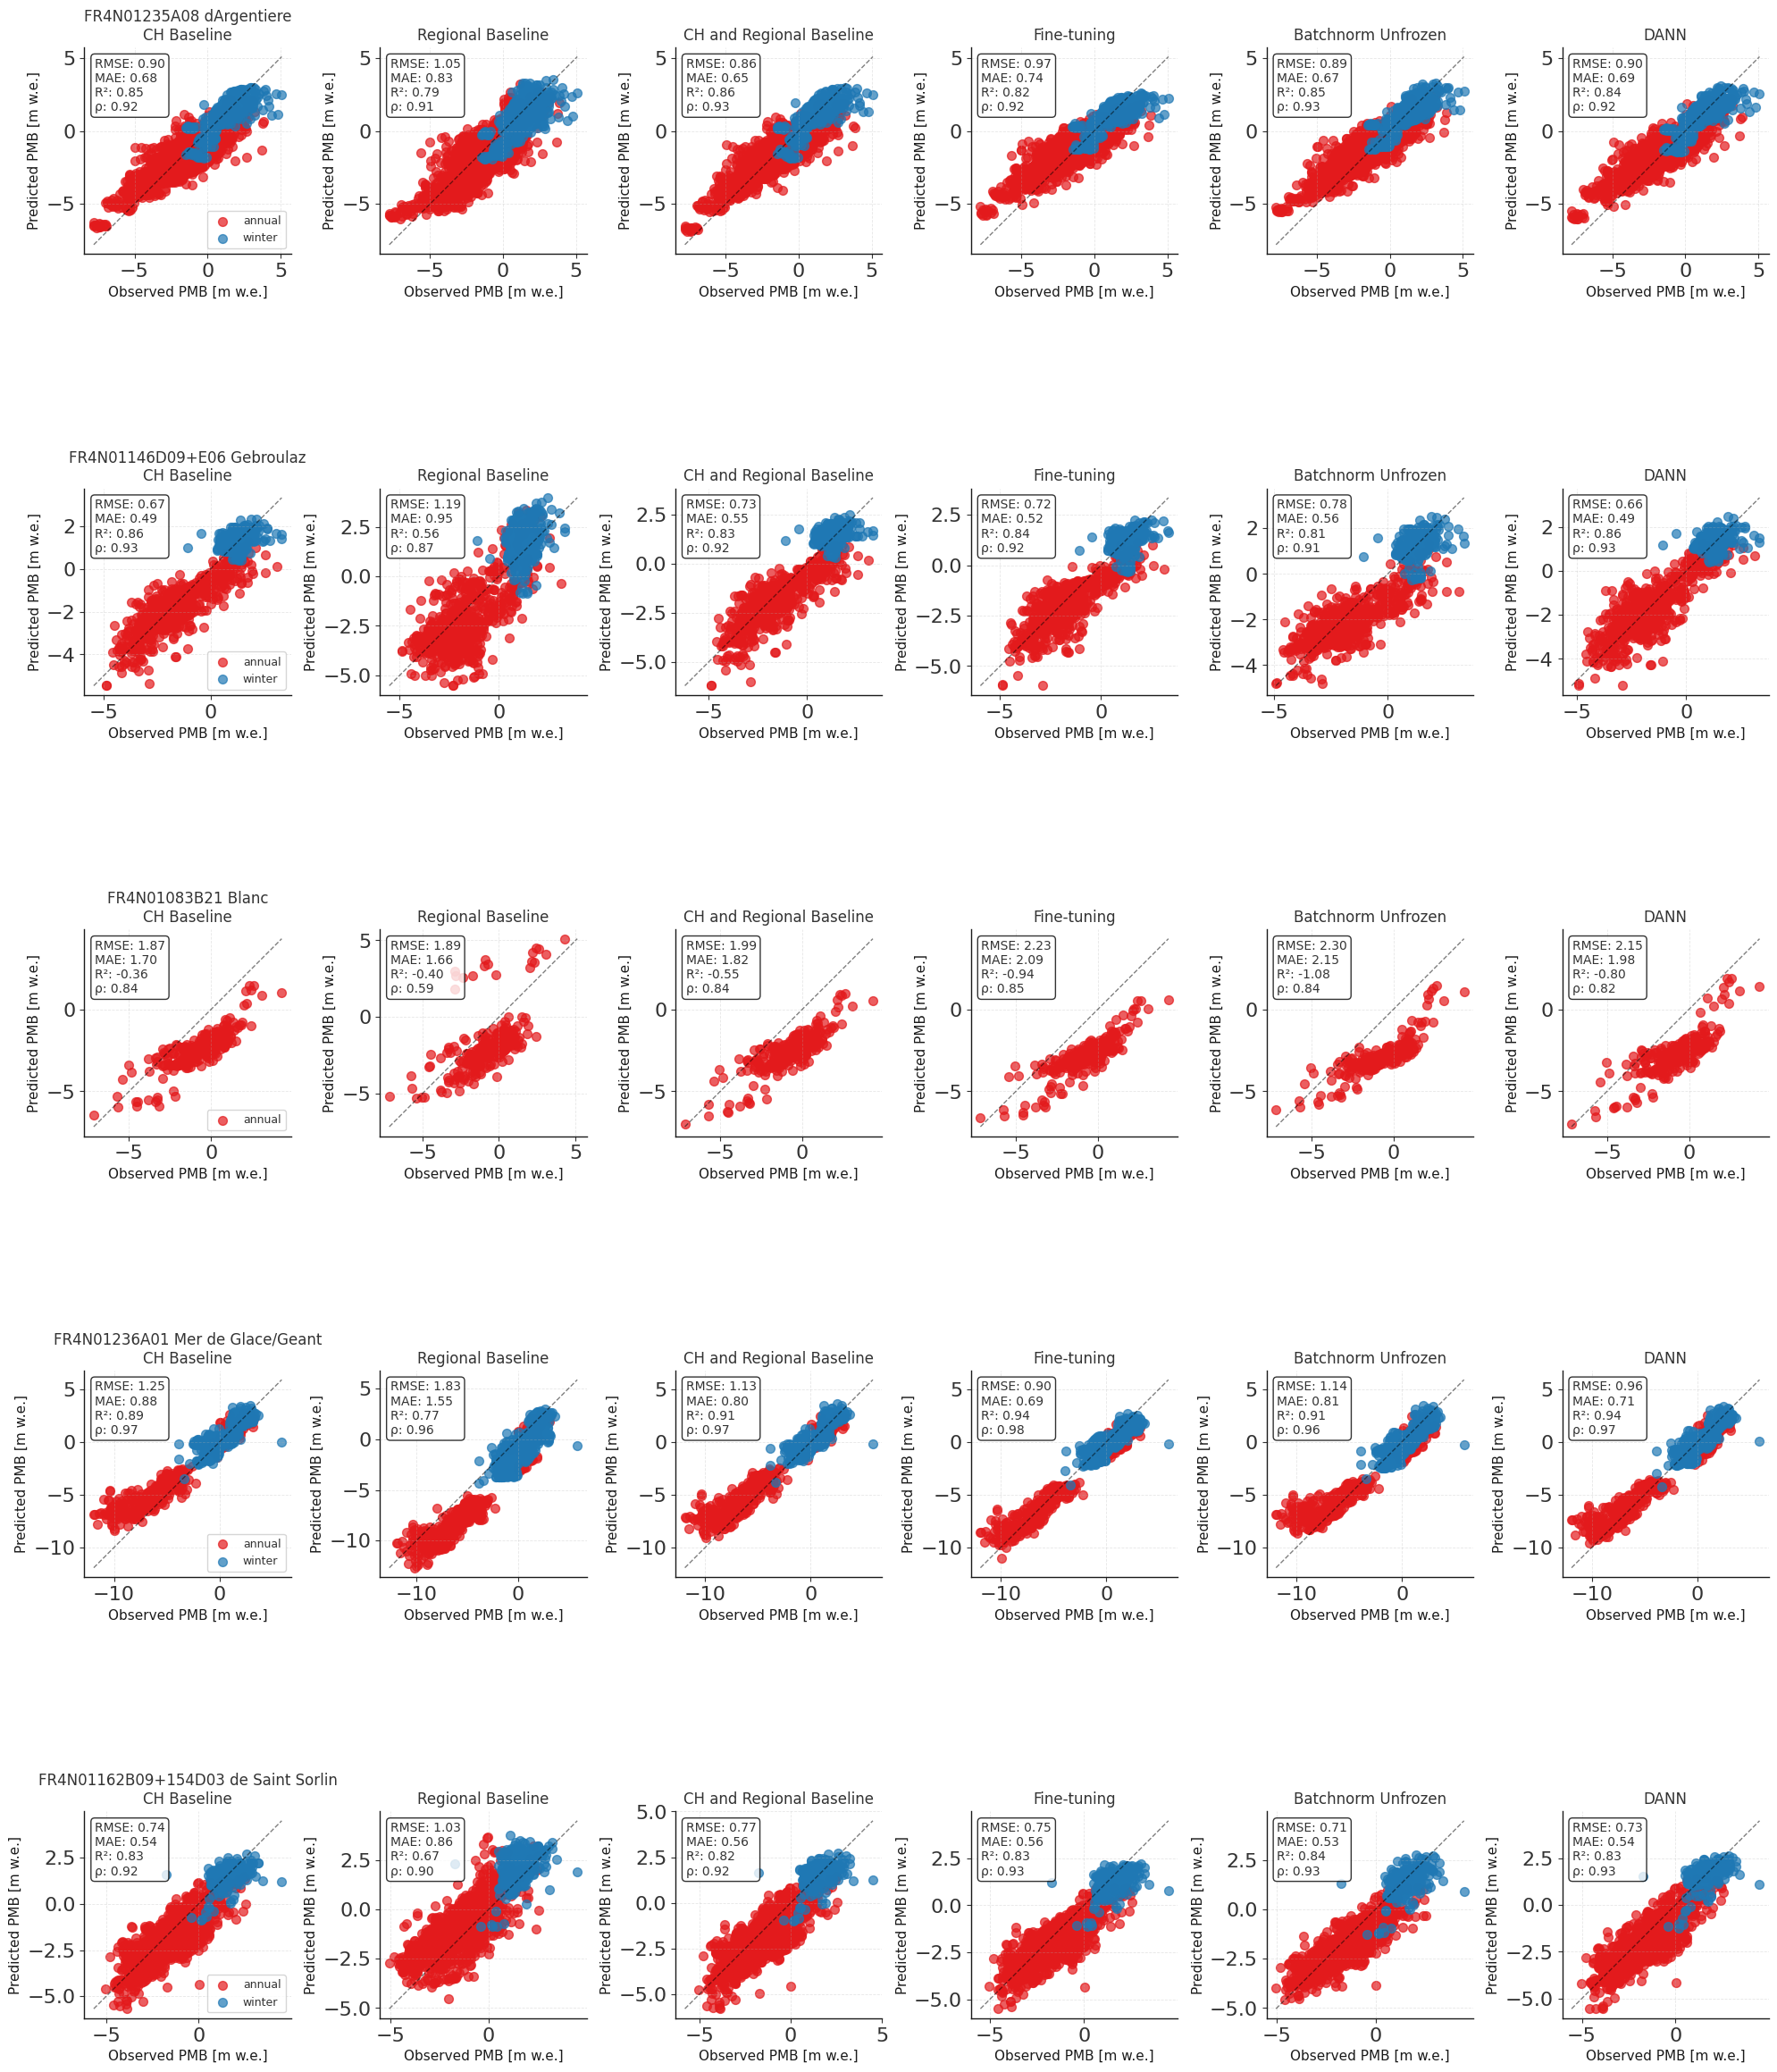

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def PlotIndividualGlacierPredVsTruth_Multi(models_grouped, base_figsize=(20, 15), height_per_row=5, ncols_models=2):
    
    # Get unique glaciers from the first model (should be same for all)
    first_model = next(iter(models_grouped.values()))
    unique_glaciers = first_model['GLACIER'].unique()
    n_glaciers = len(unique_glaciers)
    
    # Color palette for periods
    color_palette_period = {
        'annual': '#e31a1c',
        'winter': '#1f78b4'
    }
    
    # Calculate subplot layout
    n_models = len(models_grouped)
    ncols_total = min(ncols_models, n_models)
    nrows_models = int(np.ceil(n_models / ncols_total))
    
    # Create figure with subplots for each glacier
    fig = plt.figure(figsize=(base_figsize[0], n_glaciers * height_per_row))
    
    for glacier_idx, glacier_name in enumerate(unique_glaciers):
        # Create a grid for this glacier's models
        for model_idx, (model_name, model_df) in enumerate(models_grouped.items()):
            
            # Calculate subplot position
            subplot_idx = glacier_idx * n_models + model_idx + 1
            ax = plt.subplot(n_glaciers, n_models, subplot_idx)
            
            # Filter data for this glacier
            df_gl = model_df[model_df['GLACIER'] == glacier_name].copy()
            
            if len(df_gl) == 0:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{glacier_name}\n{model_name}', fontsize=12)
                continue
            
            # Calculate metrics including R²
            y_true = df_gl['target'].values
            y_pred = df_gl['pred'].values
            
            scores = {
                'mse': mean_squared_error(y_true, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                'mae': mean_absolute_error(y_true, y_pred),
                'r2': r2_score(y_true, y_pred),
                'pearson_corr': np.corrcoef(y_true, y_pred)[0, 1] if len(y_true) > 1 else np.nan
            }
            
            # Create scatter plot colored by period
            for period in df_gl['PERIOD'].unique():
                if period in color_palette_period:
                    period_data = df_gl[df_gl['PERIOD'] == period]
                    ax.scatter(period_data['target'], period_data['pred'], 
                             c=color_palette_period[period], 
                             label=period, alpha=0.7, s=50)
            
            # Add 1:1 line
            min_val = min(df_gl['target'].min(), df_gl['pred'].min())
            max_val = max(df_gl['target'].max(), df_gl['pred'].max())
            ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1)

            ax.set_aspect('equal', adjustable='box')
            
            # Add metrics text
            metrics_text = (f"RMSE: {scores['rmse']:.2f}\n"
                          f"MAE: {scores['mae']:.2f}\n" 
                          f"R²: {scores['r2']:.2f}\n"
                          f"ρ: {scores['pearson_corr']:.2f}")
            
            ax.text(0.05, 0.95, metrics_text, transform=ax.transAxes,
                   verticalalignment='top', fontsize=10,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
            
            # Set labels and title
            ax.set_xlabel('Observed PMB [m w.e.]', fontsize=11)
            ax.set_ylabel('Predicted PMB [m w.e.]', fontsize=11)
            
            # Title shows glacier name for first model in row, model name for all
            if model_idx == 0:
                title = f'{glacier_name}\n{model_name}'
            else:
                title = model_name
            ax.set_title(title, fontsize=12)
            
            # Add legend only for first subplot of each glacier
            if model_idx == 0:
                ax.legend(fontsize=9, loc='lower right')
            
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

PlotIndividualGlacierPredVsTruth_Multi(models_grouped, base_figsize=(20, 15))

In [ ]:
def compute_feature_importances_per_glacier(data, features, target_col='POINT_BALANCE', min_samples=30):
    """Compute feature importances for each glacier using RandomForestRegressor."""
    glaciers = data['GLACIER'].unique()
    importances = []
    for glacier in glaciers:
        df = data[data['GLACIER'] == glacier][features + [target_col]].dropna()
        if len(df) >= min_samples:
            rf = RandomForestRegressor(n_estimators=100, random_state=42)
            X = df[features]
            y = df[target_col]
            rf.fit(X, y)
            importances.append({'GLACIER': glacier, **dict(zip(features, rf.feature_importances_)), 'N_SAMPLES': len(df)})
    return pd.DataFrame(importances)

# Features to use
features = ['t2m', 'tp', 'ssrd', 'ELEVATION_DIFFERENCE']

# Compute importances for all glaciers
importances_df = compute_feature_importances_per_glacier(data_monthly_FR_CH, features)

# Get Blanc's importances
blanc_row = importances_df[importances_df['GLACIER'] == 'FR4N01083B21 Blanc']
if not blanc_row.empty:
    blanc_importances = blanc_row[features].values[0]
    # Compute L1 distance to all other glaciers
    importances_df['similarity_score'] = importances_df[features].apply(
        lambda row: np.sum(np.abs(row.values - blanc_importances)), axis=1
    )
    # Exclude Blanc itself
    similar_df = importances_df[importances_df['GLACIER'] != 'FR4N01083B21 Blanc'].sort_values('similarity_score')
    print("Top 10 glaciers with most similar feature importances to Blanc:")
    display(similar_df[['GLACIER', 'similarity_score', 'N_SAMPLES'] + features].head(10))
else:
    print("Blanc not found in importances_df")

In [32]:
# Analyze correlations for EACH glacier individually
def analyze_individual_glacier_correlations(data_monthly_FR_CH):
    """
    Calculate correlations for each glacier individually to see if Blanc is truly unique
    """
    
    # Features to analyze
    features = ['t2m', 'tp', 'ssrd', 'ELEVATION_DIFFERENCE']
    
    # Calculate correlations for each glacier
    glacier_correlations = []
    
    for glacier in data_monthly_FR_CH['GLACIER'].unique():
        glacier_data = data_monthly_FR_CH[data_monthly_FR_CH['GLACIER'] == glacier]
        
        if len(glacier_data) >= 10:  # Need minimum samples for reliable correlation
            correlations = {}
            correlations['GLACIER'] = glacier
            correlations['N_SAMPLES'] = len(glacier_data)
            
            for feature in features:
                corr = glacier_data[['POINT_BALANCE', feature]].corr().iloc[0,1]
                correlations[f'{feature}_corr'] = corr
            
            glacier_correlations.append(correlations)
    
    corr_df = pd.DataFrame(glacier_correlations)
    
    # Display results
    print("=== INDIVIDUAL GLACIER CORRELATIONS ===")
    print(f"Total glaciers analyzed: {len(corr_df)}")
    
    # Sort by different features to see patterns
    for feature in features:
        print(f"\n--- {feature} correlation with POINT_BALANCE ---")
        feature_col = f'{feature}_corr'
        sorted_df = corr_df.sort_values(feature_col, ascending=False)
        
        print("Top 5 highest correlations:")
        display(sorted_df[['GLACIER', feature_col, 'N_SAMPLES']].head())
        
        print("Top 5 lowest correlations:")
        display(sorted_df[['GLACIER', feature_col, 'N_SAMPLES']].tail())
        
        
        blanc_corr = sorted_df[sorted_df['GLACIER'] == 'FR4N01083B21 Blanc'][feature_col].values[0]
        print(f"Blanc correlation = {blanc_corr:.3f}")

    return corr_df

# Run the individual analysis
individual_corr_df = analyze_individual_glacier_correlations(data_monthly_FR_CH)

=== INDIVIDUAL GLACIER CORRELATIONS ===
Total glaciers analyzed: 48

--- t2m correlation with POINT_BALANCE ---
Top 5 highest correlations:


,GLACIER,t2m_corr,N_SAMPLES
47,witenwasseren,4.909023e-16,33
44,tortin,-8.423499e-03,387
30,oberaar,-1.319493e-02,197
2,FR4N01083B21 Blanc,-3.144488e-02,3471
15,chessjen,-3.266843e-02,260


Top 5 lowest correlations:


,GLACIER,t2m_corr,N_SAMPLES
31,otemma,-0.262853,3228
1,FR4N01146D09+E06 Gebroulaz,-0.265575,12495
4,FR4N01236A01 Leschaux,-0.272894,2976
6,FR4N01163A02 de Sarennes 1,-0.314605,650
42,taelliboden,NaN,12


Blanc correlation = -0.031

--- tp correlation with POINT_BALANCE ---
Top 5 highest correlations:


,GLACIER,tp_corr,N_SAMPLES
44,tortin,0.257998,387
30,oberaar,0.172200,197
6,FR4N01163A02 de Sarennes 1,0.134334,650
2,FR4N01083B21 Blanc,0.128075,3471
17,corbassiere,0.127223,2155


Top 5 lowest correlations:


,GLACIER,tp_corr,N_SAMPLES
12,allalin,-0.121233,7586
32,pizol,-0.133215,6955
23,gorner,-0.160203,1810
37,sardona,-0.185568,24
42,taelliboden,NaN,12


Blanc correlation = 0.128

--- ssrd correlation with POINT_BALANCE ---
Top 5 highest correlations:


,GLACIER,ssrd_corr,N_SAMPLES
30,oberaar,0.142813,197
44,tortin,0.114650,387
17,corbassiere,0.028205,2155
2,FR4N01083B21 Blanc,0.015473,3471
22,gietro,0.001842,4149


Top 5 lowest correlations:


,GLACIER,ssrd_corr,N_SAMPLES
23,gorner,-0.267132,1810
10,albigna,-0.271954,192
25,hohlaub,-0.327351,1503
12,allalin,-0.339868,7586
42,taelliboden,NaN,12


Blanc correlation = 0.015

--- ELEVATION_DIFFERENCE correlation with POINT_BALANCE ---
Top 5 highest correlations:


,GLACIER,ELEVATION_DIFFERENCE_corr,N_SAMPLES
37,sardona,1.000000,24
30,oberaar,0.853636,197
22,gietro,0.840096,4149
2,FR4N01083B21 Blanc,0.717446,3471
3,FR4N01236A01 Mer de Glace/Geant,0.679850,11371


Top 5 lowest correlations:


,GLACIER,ELEVATION_DIFFERENCE_corr,N_SAMPLES
33,plainemorte,-0.076666,9960
25,hohlaub,-0.282995,1503
47,witenwasseren,-0.713364,33
14,cantun,NaN,80
42,taelliboden,NaN,12


Blanc correlation = 0.717


In [ ]:
# Find glaciers similar to Blanc
def find_similar_glaciers(corr_df, target_glacier='FR4N01083B21 Blanc'):
    """
    Find glaciers with correlation patterns similar to the target glacier
    """
    
    if target_glacier not in corr_df['GLACIER'].values:
        print(f"{target_glacier} not found in correlation data")
        return
    
    # Get Blanc's correlations
    blanc_row = corr_df[corr_df['GLACIER'] == target_glacier].iloc[0]
    
    features = ['t2m_corr', 'tp_corr', 'ssrd_corr', 'ELEVATION_DIFFERENCE_corr']
    
    print(f"=== GLACIERS SIMILAR TO {target_glacier} ===")
    print(f"{target_glacier} correlations:")
    for feature in features:
        print(f"  {feature}: {blanc_row[feature]:.3f}")
    
    similar_glaciers = []
    
    for _, row in corr_df.iterrows():
        if row['GLACIER'] == target_glacier:
            continue
            
        # Check if this glacier has similar patterns
        similar = True
        similarity_score = 0
        
        for feature in features:
            diff = abs(row[feature] - blanc_row[feature])
            similarity_score += diff
            
            if feature == 'ELEVATION_DIFFERENCE_corr' and diff > 0.3: 
                similar = False
            elif feature in ['t2m_corr', 'ssrd_corr'] and diff > 0.2: 
                similar = False
            elif feature == 'tp_corr' and diff > 0.3:
                similar = False
        
        if similar:
            similar_glaciers.append({
                'GLACIER': row['GLACIER'],
                'similarity_score': similarity_score,
                'N_SAMPLES': row['N_SAMPLES'],
                **{f: row[f] for f in features}
            })
    
    if similar_glaciers:
        similar_df = pd.DataFrame(similar_glaciers).sort_values('similarity_score')
        print(f"\nFound {len(similar_df)} glaciers with similar correlation patterns:")
        display(similar_df)
        
        train_glaciers_list = list(data_CH['GLACIER'].unique())
        similar_in_train = similar_df[similar_df['GLACIER'].isin(train_glaciers_list)]
        
        if len(similar_in_train) > 0:
            print(f"\n {len(similar_in_train)} similar glaciers found in CH training set!")
            display(similar_in_train[['GLACIER', 'similarity_score']])
        else:
            print("\n No similar glaciers found in CH training set")
            
    else:
        print("\nNo glaciers found with similar correlation patterns - Blanc appears to be unique!")
    
    return similar_glaciers

# Find similar glaciers
similar_to_blanc = find_similar_glaciers(individual_corr_df)

=== GLACIERS SIMILAR TO FR4N01083B21 Blanc ===
FR4N01083B21 Blanc correlations:
  t2m_corr: -0.031
  tp_corr: 0.128
  ssrd_corr: 0.015
  ELEVATION_DIFFERENCE_corr: 0.717

Found 12 glaciers with similar correlation patterns:


,GLACIER,similarity_score,N_SAMPLES,t2m_corr,tp_corr,ssrd_corr,ELEVATION_DIFFERENCE_corr
5,gietro,0.184113,4149,-0.059600,0.108399,0.001842,0.840096
7,oberaar,0.325905,197,-0.013195,0.172200,0.142813,0.853636
6,joeri,0.329558,354,-0.044954,0.058274,-0.009346,0.496017
2,damma,0.375014,5355,-0.074994,0.036503,-0.158252,0.651279
11,tortin,0.461285,387,-0.008423,0.257998,0.114650,0.508283
1,FR4N01236A01 Mer de Glace/Geant,0.505814,11371,-0.209508,0.013668,-0.160274,0.679850
8,rhone,0.593791,56073,-0.114397,-0.017558,-0.110786,0.478499
4,forno,0.611631,471,-0.171896,-0.039169,-0.182357,0.611340
3,findelen,0.637614,33557,-0.109292,0.018485,-0.165515,0.448257
0,FR4N01235A08 dArgentiere,0.706220,25798,-0.224177,0.023402,-0.154037,0.478141



 10 similar glaciers found in CH training set!


,GLACIER,similarity_score
5,gietro,0.184113
7,oberaar,0.325905
6,joeri,0.329558
2,damma,0.375014
11,tortin,0.461285
8,rhone,0.593791
4,forno,0.611631
3,findelen,0.637614
9,schwarzberg,0.723558
10,taelliboden,NaN
